In [1]:
from models.sequential.GRU4Rec import GRU4Rec as GRU4Rec_shift
from models.sequential.TiSASRec import TiSASRec as TiSASRec_shift
import argparse
import torch
import pandas as pd
from torch import tensor
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
class Corpus():
    def __init__(self, n_users, n_items, data):
        self.n_users = n_users
        self.n_items = n_items
        self.all_df = data

In [3]:
data = pd.read_csv('../data/4Square_NYC/data.csv')

In [4]:
corpus = Corpus(data.user_id.nunique(), 38335, data)

In [5]:
orig_corpus = Corpus(data.user_id.nunique(), 38334, data)

In [6]:
users_history = data.sort_values(['user_id', 'time']).groupby('user_id')['item_id'].apply(list)
users_timehistory = data.sort_values(['user_id', 'time']).groupby('user_id')['time'].apply(list)

In [7]:
user_history = []
lengths = []
for i, l in users_history.iteritems():
    if len(l) < 20:
        lengths.append(len(l))
        l = l + [0] * (20 - len(l))
        user_history.append(l)
    else:
        l = l[-20:]
        user_history.append(l)
        lengths.append(len(l))

# Diversity

In [8]:
class _Metrics_Object(object):
    """
    Abstract class that should be used as superclass of all metrics requiring an object, therefore a state, to be computed
    """
    def __init__(self):
        pass

    def __str__(self):
        return "{:.4f}".format(self.get_metric_value())

    def add_recommendations(self, recommended_items_ids):
        raise NotImplementedError()

    def get_metric_value(self):
        raise NotImplementedError()

    def merge_with_other(self, other_metric_object):
        raise NotImplementedError()

In [9]:
class Diversity_MeanInterList(_Metrics_Object):
    """
    MeanInterList diversity measures the uniqueness of different users' recommendation lists.
    It can be used to measure how "diversified" are the recommendations different users receive.
    While the original proposal called this metric "Personalization", we do not use this name since the highest MeanInterList diversity
    is exhibited by a non personalized Random recommender.
    pag. 3, http://www.pnas.org/content/pnas/107/10/4511.full.pdf
    @article{zhou2010solving,
      title={Solving the apparent diversity-accuracy dilemma of recommender systems},
      author={Zhou, Tao and Kuscsik, Zolt{\'a}n and Liu, Jian-Guo and Medo, Mat{\'u}{\v{s}} and Wakeling, Joseph Rushton and Zhang, Yi-Cheng},
      journal={Proceedings of the National Academy of Sciences},
      volume={107},
      number={10},
      pages={4511--4515},
      year={2010},
      publisher={National Acad Sciences}
    }
    It was demonstrated by Ferrari Dacrema that this metric does not require to compute the common items all possible
    couples of users have in common but rather it is only sensitive to the total number of times each item has been recommended.
    MeanInterList diversity is a function of the square of the probability an item has been recommended to any user, hence
    MeanInterList diversity is equivalent to the Herfindahl index as they measure the same quantity.
    See
    @inproceedings{DBLP:conf/aaai/Dacrema21,
      author    = {Maurizio {Ferrari Dacrema}},
      title     = {Demonstrating the Equivalence of List Based and Aggregate Metrics
                   to Measure the Diversity of Recommendations (Student Abstract)},
      booktitle = {Thirty-Fifth {AAAI} Conference on Artificial Intelligence, {AAAI}
                   2021, Thirty-Third Conference on Innovative Applications of Artificial
                   Intelligence, {IAAI} 2021, The Eleventh Symposium on Educational Advances
                   in Artificial Intelligence, {EAAI} 2021, Virtual Event, February 2-9,
                   2021},
      pages     = {15779--15780},
      publisher = {{AAAI} Press},
      year      = {2021},
      url       = {https://ojs.aaai.org/index.php/AAAI/article/view/17886},
    }
    A TopPopular recommender that does not remove seen items will have 0.0 MeanInterList diversity.
    # The formula is diversity_cumulative += 1 - common_recommendations(user1, user2)/cutoff
    # for each couple of users, except the diagonal. It is VERY computationally expensive
    # We can move the 1 and cutoff outside of the summation. Remember to exclude the diagonal
    # co_counts = URM_predicted.dot(URM_predicted.T)
    # co_counts[np.arange(0, n_user, dtype=np.int):np.arange(0, n_user, dtype=np.int)] = 0
    # diversity = (n_user**2 - n_user) - co_counts.sum()/self.cutoff
    # If we represent the summation of co_counts separating it for each item, we will have:
    # co_counts.sum() = co_counts_item1.sum()  + co_counts_item2.sum() ...
    # If we know how many times an item has been recommended, co_counts_item1.sum() can be computed as how many couples of
    # users have item1 in common. If item1 has been recommended n times, the number of couples is n*(n-1)
    # Therefore we can compute co_counts.sum() value as:
    # np.sum(np.multiply(item-occurrence, item-occurrence-1))
    # The naive implementation URM_predicted.dot(URM_predicted.T) might require an hour of computation
    # The last implementation has a negligible computational time even for very big datasets
    """

    def __init__(self, n_items, cutoff):
        super(Diversity_MeanInterList, self).__init__()

        self.recommended_counter = np.zeros(n_items, dtype=np.float64)

        self.n_evaluated_users = 0
        self.n_items = n_items
        self.diversity = 0.0
        self.cutoff = cutoff


    def add_recommendations(self, recommended_items_ids):

        assert len(recommended_items_ids) <= self.cutoff, "Diversity_MeanInterList: recommended list is contains more elements than cutoff"

        self.n_evaluated_users += 1

        if len(recommended_items_ids) > 0:
            self.recommended_counter[recommended_items_ids] += 1


    def get_metric_value(self):

        # Requires to compute the number of common elements for all couples of users
        if self.n_evaluated_users == 0:
            return 1.0

        cooccurrences_cumulative = np.sum(self.recommended_counter**2) - self.n_evaluated_users*self.cutoff

        # All user combinations except diagonal
        all_user_couples_count = self.n_evaluated_users**2 - self.n_evaluated_users

        diversity_cumulative = all_user_couples_count - cooccurrences_cumulative/self.cutoff

        self.diversity = diversity_cumulative/all_user_couples_count

        return self.diversity


    def get_theoretical_max(self):

        global_co_occurrence_count = (self.n_evaluated_users*self.cutoff)**2/self.n_items - self.n_evaluated_users*self.cutoff

        mild = 1 - 1/(self.n_evaluated_users**2 - self.n_evaluated_users)*(global_co_occurrence_count/self.cutoff)

        return mild

## GRU4Rec

In [10]:
# parser
parser = argparse.ArgumentParser(description='')
parser.add_argument('--gpu', type=str, default='', help='Set CUDA_VISIBLE_DEVICES, default for CPU only')
parser.add_argument('--random_seed', type=int, default=0, help='Random seed of numpy and pytorch')
parser.add_argument('--history_max', type=int, default=20, help='Maximum length of history.')
parser.add_argument('--dropout', type=float, default=0, help='Dropout probability for each deep layer')
parser.add_argument('--test_all', type=int, default=0, help='Whether testing on all the items.')
parser.add_argument('--emb_size', type=int, default=64, help='Size of embedding vectors.')
parser.add_argument('--hidden_size', type=int, default=100, help='Size of hidden vectors in GRU.')
parser.add_argument('--time_units', type=str, default='h,d', help='Time units for creating time embeddings')
parser.add_argument('--buffer', type=int, default=1, help='Whether to buffer feed dicts for dev/test')
parser.add_argument('--num_neg', type=int, default=1, help='The number of negative items during training.')
parser.add_argument('--prediction_time', type=int, default=0, help='The number of negative items during training.')
parser.add_argument('--prediction_hour', type=int, default=0, help='The number of negative items during training.')
parser.add_argument('--prediction_day', type=int, default=0, help='The number of negative items during training.')
parser.add_argument('--prediction_month', type=int, default=0, help='The number of negative items during training.')
parser.add_argument('--version', type=int, default=2, help='The number of negative items during training.')
parser.add_argument('--fullseq', type=int, default=0, help='The number of negative items during training.')
parser.add_argument('--end_item', type=bool, default=False, help='The number of negative items during training.')
args, extras = parser.parse_known_args()
args.device = torch.device('cpu')
args.model_path = '/'

In [11]:
# orig_model = GRU4Rec(args, orig_corpus)

In [12]:
# orig_model

In [13]:
# # original
# orig_model.load_state_dict(torch.load('../model/GRU4Rec_shift/GRU4Rec__4Square_NYC__0__lr=0.001__l2=0.0001__emb_size=64__hidden_size=100.pt', map_location=args.device))

In [14]:
args.prediction_time = 'hour,day'
hd_model = GRU4Rec_shift(args, orig_corpus)
hd_model.load_state_dict(torch.load('../model/GRU4Rec_shift/GRU4Rec__4Square_NYC__0__lr=0.001__l2=0.0001__emb_size=64__hidden_size=100_h,d.pt', map_location=args.device))

<All keys matched successfully>

In [15]:
args.prediction_time = 'hour'
h_model = GRU4Rec_shift(args, orig_corpus)
h_model.load_state_dict(torch.load('../model/GRU4Rec_shift/GRU4Rec__4Square_NYC__0__lr=0.001__l2=0.0001__emb_size=64__hidden_size=100_h.pt', map_location=args.device))

<All keys matched successfully>

In [16]:
args.prediction_time = 'day'
d_model = GRU4Rec_shift(args, orig_corpus)
d_model.load_state_dict(torch.load('../model/GRU4Rec_shift/GRU4Rec__4Square_NYC__0__lr=0.001__l2=0.0001__emb_size=64__hidden_size=100_d.pt', map_location=args.device))

<All keys matched successfully>

In [29]:
# feed_dict = {}
# feed_dict['item_id'] = tensor(sorted(data.item_id.unique()))
# feed_dict['batch_size'] = 1
# feed_dict['phase'] = 'test'
# item1 = 183 # music
# item2 = 2256 # bus station

# days = np.arange(2,9)
# hours = np.arange(24)
# grid = np.meshgrid(hours, days)

# users = data.user_id.unique()
# # hd_metrics = np.empty((10, data.user_id.nunique()))
# # h_metrics = np.empty((10, data.user_id.nunique()))
# # d_metrics = np.empty((10, data.user_id.nunique()))

# bus_scores = np.empty((24*7, len(users)))
# music_scores = np.empty((24*7, len(users)))
# bus_ranks = np.empty((24*7, len(users)))
# music_ranks = np.empty((24*7, len(users)))
    
# for i, user_id in tqdm(enumerate(users), total=len(users)):
# #     hd_divs = [Diversity_MeanInterList(38333, j) for j in range(5,55,5)]
# #     h_divs = [Diversity_MeanInterList(38333, j) for j in range(5,55,5)]
# #     d_divs = [Diversity_MeanInterList(38333, j) for j in range(5,55,5)]

#     feed_dict['user_id'] = tensor([user_id])
#     feed_dict['history_items'] = tensor(user_history[i]).unsqueeze(0)
#     feed_dict['lengths'] = tensor(lengths[i]).unsqueeze(0)    
    
#     for k, (hour, day) in enumerate(zip(grid[0].flatten(), grid[1].flatten())):
#         next_time = (pd.Timestamp("2023-01-{:02d} {:02d}:00:00".format(day, hour)) - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
#         l = users_timehistory.values[i]
#         if len(l) < 19:
#             l = l + [next_time] + [0] * (19 - len(l))
#         else:
#             l = l[-19:] + [next_time]
#         feed_dict['history_hours'] = tensor([datetime.fromtimestamp(x).hour + 1 if x != 0 else x for x in l]).unsqueeze(0)
#         feed_dict['history_hours_shift'] = tensor([datetime.fromtimestamp(x).hour + 1  if x != 0 else x for x in l]).unsqueeze(0)
#         feed_dict['history_days'] = tensor([datetime.fromtimestamp(x).weekday() + 1  if x != 0 else x for x in l]).unsqueeze(0)
#         feed_dict['history_days_shift'] = tensor([datetime.fromtimestamp(x).weekday() + 1 if x != 0 else x for x in l]).unsqueeze(0)
#         feed_dict['history_months'] = tensor([datetime.fromtimestamp(x).weekday() + 1 if x != 0 else x for x in l]).unsqueeze(0)
#         feed_dict['history_months_shift'] = tensor([datetime.fromtimestamp(x).weekday() + 1 if x != 0 else x for x in l]).unsqueeze(0)
        
#         hd_pred = hd_model(feed_dict)['prediction'].squeeze(0)
#         h_pred = h_model(feed_dict)['prediction'].squeeze(0)
#         d_pred = d_model(feed_dict)['prediction'].squeeze(0)
        
#         hd_pred_items = (-hd_pred).argsort()
#         h_pred_items = (-h_pred).argsort()
#         d_pred_items = (-d_pred).argsort()
        
#         music_scores[k][i] = hd_pred[item1-1]
#         bus_scores[k][i] = hd_pred[item2-1]
#         music_ranks[k][i] = torch.nonzero(hd_pred_items==item1-1).item()
#         bus_ranks[k][i] = torch.nonzero(hd_pred_items==item2-1).item()
        
# #         for j, d in enumerate(hd_divs):
# #             d.add_recommendations(hd_pred_items[:(j+1)*5])
# #         for j, d in enumerate(h_divs):
# #             d.add_recommendations(h_pred_items[:(j+1)*5])
# #         for j, d in enumerate(d_divs):
# #             d.add_recommendations(d_pred_items[:(j+1)*5])
    
            
# #     for j, d in enumerate(hd_divs):
# #         hd_metrics[j][i] = d.get_metric_value()
# #     for j, d in enumerate(h_divs):
# #         h_metrics[j][i] = d.get_metric_value()
# #     for j, d in enumerate(d_divs):
# #         d_metrics[j][i] = d.get_metric_value()

  0%|          | 0/1083 [00:00<?, ?it/s]

In [30]:
music = 4.589302498838647
bus = 6.478783460535171
music_rank = 2585.759002770083
bus_rank = 476.0156971375808

In [61]:
bus_scores.mean(1)

array([6.47171691, 6.46471696, 6.45847931, 6.46125676, 6.46106757,
       6.45603811, 6.43868754, 6.48063777, 6.47902683, 6.49361036,
       6.47719653, 6.45034057, 6.45322883, 6.43905667, 6.45741702,
       6.45096017, 6.45741649, 6.46662854, 6.46169287, 6.45513608,
       6.44917182, 6.47316706, 6.49947379, 6.48973207, 6.48252602,
       6.47889624, 6.47405165, 6.47828002, 6.47650381, 6.4722188 ,
       6.45515504, 6.49199681, 6.48701303, 6.49486636, 6.47587602,
       6.44806848, 6.45074801, 6.43650905, 6.45376609, 6.44827564,
       6.45478166, 6.46430309, 6.45926212, 6.45257439, 6.44702557,
       6.46552754, 6.49144536, 6.48057775, 6.47197289, 6.46763455,
       6.46251063, 6.4664608 , 6.46500053, 6.46055189, 6.44343747,
       6.48134087, 6.47708613, 6.48644981, 6.46807842, 6.44084204,
       6.44385685, 6.43016431, 6.44801055, 6.4418828 , 6.44805272,
       6.45734487, 6.45218243, 6.44536714, 6.43965355, 6.47811623,
       6.50325796, 6.48937777, 6.47643225, 6.46972981, 6.46359

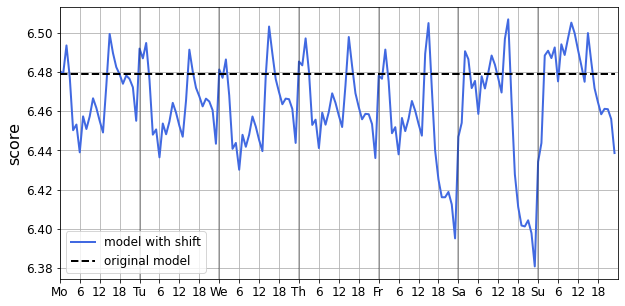

In [31]:
fig = plt.figure(figsize=(10,5))
#     plt.title(f'Average score of item of category "{k}" during week')
plt.plot(np.roll(bus_scores.mean(1),-7), color='royalblue', linewidth=2, label='model with shift')
plt.plot(np.ones_like(bus_scores.mean(1))*bus, color='k', linestyle='--', linewidth=2, label='original model')
plt.xticks(6*np.arange(4*7), ['Mo', 6, 12, 18, 'Tu', 6, 12, 18, 'We', 6, 12, 18, 'Th', 6, 12, 18, 'Fr', 6, 12, 18, 'Sa', 6, 12, 18, 'Su', 6, 12, 18], fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('score', fontsize=16)
plt.xlim(0, 24*7)
plt.grid(True)
for i in range(1, 7):
    plt.axvline(24*i, color='k', alpha=0.3)
plt.legend(fontsize=12)
plt.show()
fig.savefig(f'bus_scores_h,d.svg', format='svg', dpi=1400, bbox_inches='tight')

In [62]:
bus_ranks.mean(1)

array([379.42936288, 403.37950139, 415.27239151, 427.30747922,
       412.75253924, 421.0212373 , 432.46999077, 378.02216066,
       363.00738689, 349.08679594, 363.30470914, 426.19298246,
       450.06001847, 495.45614035, 505.28716528, 484.35826408,
       457.86703601, 444.60757156, 431.3721145 , 416.1634349 ,
       414.93998153, 388.24930748, 362.33610342, 350.17174515,
       364.60387812, 383.56509695, 394.18374885, 405.10249307,
       391.75069252, 399.43028624, 410.21883657, 362.55493998,
       353.23361034, 352.89012004, 373.73314866, 443.74607572,
       467.45060018, 509.53185596, 517.09972299, 499.06740536,
       474.90120037, 461.99353647, 448.95106187, 433.43767313,
       432.2132964 , 387.388735  , 362.23638042, 352.66851339,
       370.3434903 , 390.77285319, 401.94921514, 413.11634349,
       399.53185596, 407.19390582, 418.2299169 , 368.38042475,
       357.68328717, 353.95106187, 373.30286242, 442.10526316,
       465.97783934, 508.88827331, 516.94367498, 498.17

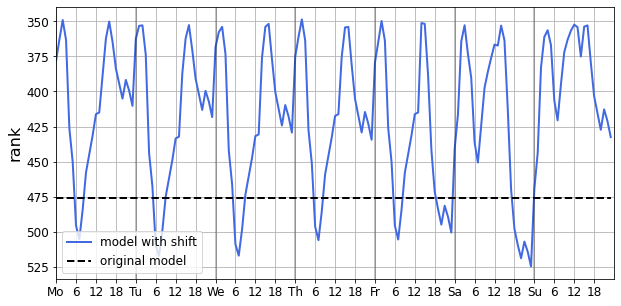

In [39]:
fig = plt.figure(figsize=(10,5))
#     plt.title(f'Average score of item of category "{k}" during week')
plt.plot(np.roll(bus_ranks.mean(1),-7), color='royalblue', linewidth=2, label='model with shift')
plt.plot(np.ones_like(bus_ranks.mean(1))*bus_rank, color='k', linestyle='--', linewidth=2, label='original model')
plt.xticks(6*np.arange(4*7), ['Mo', 6, 12, 18, 'Tu', 6, 12, 18, 'We', 6, 12, 18, 'Th', 6, 12, 18, 'Fr', 6, 12, 18, 'Sa', 6, 12, 18, 'Su', 6, 12, 18], fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('rank', fontsize=16)
plt.xlim(0, 24*7)
plt.grid(True)
for i in range(1, 7):
    plt.axvline(24*i, color='k', alpha=0.3)
plt.legend(fontsize=12)
plt.gca().invert_yaxis()
plt.show()
fig.savefig(f'bus_ranks_h,d.svg', format='svg', dpi=1400, bbox_inches='tight')

In [63]:
music_scores.mean(1)

array([4.92231979, 5.11803061, 5.17886828, 5.26074395, 5.16636957,
       5.20934758, 5.24429705, 4.93316844, 4.73405196, 4.24913751,
       3.92657686, 3.26461093, 3.04260879, 2.74142644, 2.63598533,
       2.80572822, 2.97697152, 3.08994882, 3.20509335, 3.33550741,
       3.38757967, 3.58632863, 3.86977953, 4.33375325, 4.77366   ,
       4.98916068, 5.05939766, 5.15186648, 5.04548975, 5.09410971,
       5.13390348, 4.78619305, 4.57093279, 4.06371738, 3.74080244,
       3.1105652 , 2.90641992, 2.635386  , 2.54265536, 2.69408031,
       2.84748633, 2.95186873, 3.05693516, 3.17598539, 3.22550985,
       3.63054456, 3.91576726, 4.37808219, 4.81113562, 5.02167758,
       5.08953754, 5.17932449, 5.07602317, 5.12317086, 5.16169117,
       4.82331255, 4.61199236, 4.10975776, 3.78641626, 3.14738841,
       2.93871332, 2.66023508, 2.56446709, 2.72030365, 2.8781109 ,
       2.98462611, 3.09224899, 3.21424624, 3.26440991, 3.7538311 ,
       4.04224319, 4.49861832, 4.91365269, 5.11179381, 5.17377

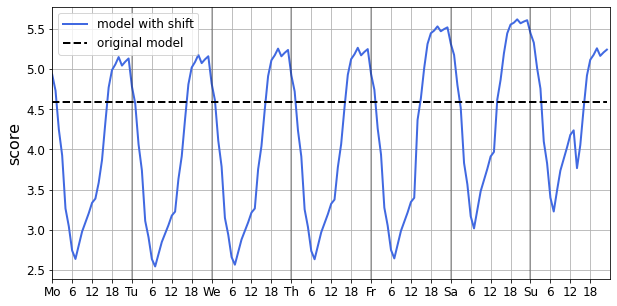

In [35]:
fig = plt.figure(figsize=(10,5))
#     plt.title(f'Average score of item of category "{k}" during week')
plt.plot(np.roll(music_scores.mean(1),-7), color='royalblue', linewidth=2, label='model with shift')
plt.plot(np.ones_like(music_scores.mean(1))*music, color='k', linestyle='--', linewidth=2, label='original model')
plt.xticks(6*np.arange(4*7), ['Mo', 6, 12, 18, 'Tu', 6, 12, 18, 'We', 6, 12, 18, 'Th', 6, 12, 18, 'Fr', 6, 12, 18, 'Sa', 6, 12, 18, 'Su', 6, 12, 18], fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('score', fontsize=16)
plt.xlim(0, 24*7)
plt.grid(True)
for i in range(1, 7):
    plt.axvline(24*i, color='k', alpha=0.3)
plt.legend(fontsize=12)
plt.show()
fig.savefig(f'music_scores_h,d.svg', format='svg', dpi=1400, bbox_inches='tight')

In [64]:
music_ranks.mean(1)

array([3090.98245614, 2825.63250231, 2749.39704524, 2648.61680517,
       2767.50046168, 2711.68513389, 2666.55401662, 3080.12003693,
       3374.89658356, 4214.45521699, 4879.69806094, 6533.8578024 ,
       7173.31301939, 8104.89381348, 8454.67313019, 7905.39427516,
       7373.11357341, 7042.289012  , 6707.39981533, 6338.72022161,
       6198.69806094, 5683.79501385, 5010.3721145 , 4053.87534626,
       3312.5521699 , 3001.52816251, 2908.21883657, 2789.72760849,
       2929.00092336, 2863.46075716, 2810.35087719, 3297.62973223,
       3639.17359187, 4587.40904894, 5305.08494922, 6974.36842105,
       7585.1089566 , 8448.36472761, 8760.73130194, 8262.44967682,
       7771.14496768, 7455.48014774, 7138.39150508, 6785.31117267,
       6646.97322253, 5572.21975993, 4905.85595568, 3970.35364728,
       3254.24930748, 2955.12188366, 2866.1421976 , 2752.88180979,
       2886.50507849, 2823.4478301 , 2772.70637119, 3240.39150508,
       3569.58910434, 4491.09048938, 5197.01846722, 6865.90120

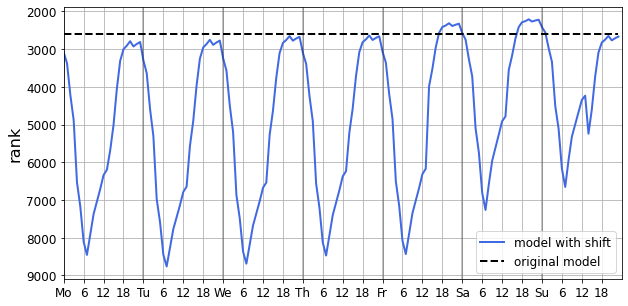

In [36]:
fig = plt.figure(figsize=(10,5))
#     plt.title(f'Average score of item of category "{k}" during week')
plt.plot(np.roll(music_ranks.mean(1),-7), color='royalblue', linewidth=2, label='model with shift')
plt.plot(np.ones_like(music_ranks.mean(1))*music_rank, color='k', linestyle='--', linewidth=2, label='original model')
plt.xticks(6*np.arange(4*7), ['Mo', 6, 12, 18, 'Tu', 6, 12, 18, 'We', 6, 12, 18, 'Th', 6, 12, 18, 'Fr', 6, 12, 18, 'Sa', 6, 12, 18, 'Su', 6, 12, 18], fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('rank', fontsize=16)
plt.xlim(0, 24*7)
plt.grid(True)
for i in range(1, 7):
    plt.axvline(24*i, color='k', alpha=0.3)
plt.legend(fontsize=12)
plt.gca().invert_yaxis()
plt.show()
fig.savefig(f'music_ranks_h,d.svg', format='svg', dpi=1400, bbox_inches='tight')

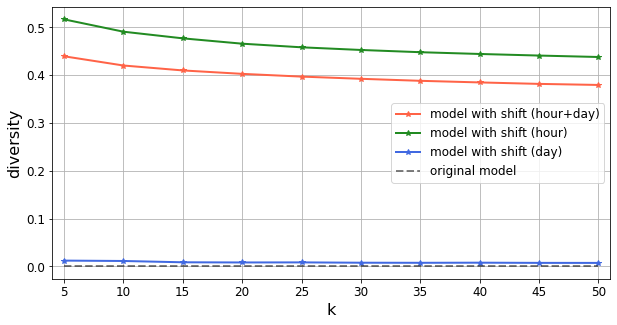

In [27]:
fig = plt.figure(figsize=(10,5))
# plt.title(f'Diversity of top-k recommendations given time context')
plt.plot(np.arange(5,55,5), hd_metrics.mean(1), color='tomato', marker='*', linewidth=2, label='model with shift (hour+day)')
plt.plot(np.arange(5,55,5), h_metrics.mean(1), color='forestgreen', marker='*', linewidth=2, label='model with shift (hour)')
plt.plot(np.arange(5,55,5), d_metrics.mean(1), color='royalblue', marker='*', linewidth=2, label='model with shift (day)')
plt.plot(np.arange(5,55,5), np.zeros_like(hd_metrics.mean(1)), color='k', linestyle='--', linewidth=2, alpha=0.5, label='original model')
plt.xticks(np.arange(5,55,5), fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('k', fontsize=16)
plt.ylabel('diversity', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.xlim(4,51)
plt.show()
fig.savefig(f'gru4rec_div.svg', format='svg', dpi=1400, bbox_inches='tight')

## TiSASRec

In [10]:
# parser
parser = argparse.ArgumentParser(description='')
parser.add_argument('--gpu', type=str, default='', help='Set CUDA_VISIBLE_DEVICES, default for CPU only')
parser.add_argument('--random_seed', type=int, default=0, help='Random seed of numpy and pytorch')
parser.add_argument('--history_max', type=int, default=20, help='Maximum length of history.')
parser.add_argument('--dropout', type=float, default=0, help='Dropout probability for each deep layer')
parser.add_argument('--test_all', type=int, default=0, help='Whether testing on all the items.')
parser.add_argument('--emb_size', type=int, default=64, help='Size of embedding vectors.')
parser.add_argument('--buffer', type=int, default=1, help='Whether to buffer feed dicts for dev/test')
parser.add_argument('--num_neg', type=int, default=1, help='The number of negative items during training.')
parser.add_argument('--num_layers', type=int, default=2, help='The number of negative items during training.')
parser.add_argument('--num_heads', type=int, default=2, help='The number of negative items during training.')
parser.add_argument('--time_max', type=int, default=512,help='Max time intervals.')
parser.add_argument('--prediction_time', type=int, default=0, help='The number of negative items during training.')
parser.add_argument('--prediction_hour', type=int, default=0, help='The number of negative items during training.')
parser.add_argument('--prediction_day', type=int, default=0, help='The number of negative items during training.')
parser.add_argument('--prediction_month', type=int, default=0, help='The number of negative items during training.')
parser.add_argument('--version', type=int, default=4, help='The number of negative items during training.')
parser.add_argument('--fullseq', type=int, default=0, help='The number of negative items during training.')
parser.add_argument('--end_item', type=bool, default=False, help='The number of negative items during training.')
parser.add_argument('--n_dft', type=int, default=64, help='The point of DFT.')
args, extras = parser.parse_known_args()
args.device = torch.device('cpu')
args.model_path = '/'

In [11]:
args.prediction_time = 'hour,day'
hd_model = TiSASRec_shift(args, orig_corpus)
hd_model.load_state_dict(torch.load('../model/TiSASRec_shift/TiSASRec__4Square_NYC__0__lr=0.0001__l2=1e-06__emb_size=64__num_layers=2__num_heads=2__time_max=512_h,d.pt', map_location=args.device))

<All keys matched successfully>

In [12]:
args.prediction_time = 'hour'
h_model = TiSASRec_shift(args, orig_corpus)
h_model.load_state_dict(torch.load('../model/TiSASRec_shift/TiSASRec__4Square_NYC__0__lr=0.0001__l2=1e-06__emb_size=64__num_layers=2__num_heads=2__time_max=512_h.pt', map_location=args.device))

<All keys matched successfully>

In [13]:
args.prediction_time = 'day'
d_model = TiSASRec_shift(args, orig_corpus)
d_model.load_state_dict(torch.load('../model/TiSASRec_shift/TiSASRec__4Square_NYC__0__lr=0.0001__l2=1e-06__emb_size=64__num_layers=2__num_heads=2__time_max=512_d.pt', map_location=args.device))

<All keys matched successfully>

In [14]:
# feed_dict = {}
# feed_dict['item_id'] = tensor(sorted(data.item_id.unique())).unsqueeze(0)
# feed_dict['batch_size'] = 1
# feed_dict['phase'] = 'test'
# item1 = 183 # music
# item2 = 2256 # bus station

# days = np.arange(2,9)
# hours = np.arange(24)
# grid = np.meshgrid(hours, days)

# users = data.user_id.unique()
# hd_metrics = np.empty((10, data.user_id.nunique()))
# h_metrics = np.empty((10, data.user_id.nunique()))
# d_metrics = np.empty((10, data.user_id.nunique()))

# bus_scores = np.empty((24*7, len(users)))
# music_scores = np.empty((24*7, len(users)))
# bus_ranks = np.empty((24*7, len(users)))
# music_ranks = np.empty((24*7, len(users)))
    
# for i, user_id in tqdm(enumerate(users), total=len(users)):
#     hd_divs = [Diversity_MeanInterList(38333, j) for j in range(5,55,5)]
#     h_divs = [Diversity_MeanInterList(38333, j) for j in range(5,55,5)]
#     d_divs = [Diversity_MeanInterList(38333, j) for j in range(5,55,5)]

#     feed_dict['user_id'] = tensor([user_id])
#     feed_dict['history_items'] = tensor(user_history[i]).unsqueeze(0)
#     feed_dict['lengths'] = tensor(lengths[i]).unsqueeze(0)    
    
#     for k, (hour, day) in enumerate(zip(grid[0].flatten(), grid[1].flatten())):
#         next_time = (pd.Timestamp("2023-01-{:02d} {:02d}:00:00".format(day, hour)) - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
#         l = users_timehistory.values[i]
#         if len(l) < 19:
#             l = l + [next_time] + [0] * (19 - len(l))
#         else:
#             l = l[-19:] + [next_time]
#         feed_dict['history_times'] = tensor(l).unsqueeze(0)
#         feed_dict['history_hours'] = tensor([datetime.fromtimestamp(x).hour + 1 if x != 0 else x for x in l]).unsqueeze(0)
#         feed_dict['history_hours_shift'] = tensor([datetime.fromtimestamp(x).hour + 1  if x != 0 else x for x in l]).unsqueeze(0)
#         feed_dict['history_days'] = tensor([datetime.fromtimestamp(x).weekday() + 1  if x != 0 else x for x in l]).unsqueeze(0)
#         feed_dict['history_days_shift'] = tensor([datetime.fromtimestamp(x).weekday() + 1 if x != 0 else x for x in l]).unsqueeze(0)
#         feed_dict['history_months'] = tensor([datetime.fromtimestamp(x).month + 1 if x != 0 else x for x in l]).unsqueeze(0)
#         feed_dict['history_months_shift'] = tensor([datetime.fromtimestamp(x).month + 1 if x != 0 else x for x in l]).unsqueeze(0)
#         feed_dict['hours'] = tensor([datetime.fromtimestamp(next_time).hour + 1])
#         feed_dict['days'] = tensor([datetime.fromtimestamp(next_time).weekday() + 1])
#         feed_dict['months'] = tensor([datetime.fromtimestamp(next_time).month + 1])
        
#         feed_dict['user_min_intervals'] = tensor(hd_model.user_min_interval[user_id]).unsqueeze(0)
#         hd_pred = hd_model(feed_dict)['prediction'].squeeze(0)
#         h_pred = h_model(feed_dict)['prediction'].squeeze(0)
#         d_pred = d_model(feed_dict)['prediction'].squeeze(0)
        
#         hd_pred_items = (-hd_pred).argsort()
#         h_pred_items = (-h_pred).argsort()
#         d_pred_items = (-d_pred).argsort()
        
#         music_scores[k][i] = hd_pred[item1-1]
#         bus_scores[k][i] = hd_pred[item2-1]
#         music_ranks[k][i] = torch.nonzero(hd_pred_items==item1-1).item()
#         bus_ranks[k][i] = torch.nonzero(hd_pred_items==item2-1).item()
        
#         for j, d in enumerate(hd_divs):
#             d.add_recommendations(hd_pred_items[:(j+1)*5])
#         for j, d in enumerate(h_divs):
#             d.add_recommendations(h_pred_items[:(j+1)*5])
#         for j, d in enumerate(d_divs):
#             d.add_recommendations(d_pred_items[:(j+1)*5])
    
            
#     for j, d in enumerate(hd_divs):
#         hd_metrics[j][i] = d.get_metric_value()
#     for j, d in enumerate(h_divs):
#         h_metrics[j][i] = d.get_metric_value()
#     for j, d in enumerate(d_divs):
#         d_metrics[j][i] = d.get_metric_value()

  0%|          | 0/1083 [00:00<?, ?it/s]

In [15]:
hd_metrics.mean(1)

array([0.08906706, 0.08991914, 0.08793745, 0.08809756, 0.087263  ,
       0.08644065, 0.08658748, 0.08687639, 0.08666502, 0.08610789])

In [16]:
h_metrics.mean(1)

array([0.09351537, 0.09285644, 0.09310855, 0.09310269, 0.09149761,
       0.09175467, 0.09223566, 0.09169194, 0.09164347, 0.09162327])

In [17]:
d_metrics.mean(1)

array([0.0486056 , 0.04786628, 0.0468742 , 0.04692601, 0.04719672,
       0.04612729, 0.04570248, 0.04500094, 0.04484791, 0.0443509 ])

In [19]:
music = 3.8129046326116183
bus = 5.038432892408507
music_rank = 3182.7682363804247
bus_rank = 2637.8716528162513

In [20]:
bus_scores.mean(1)

array([4.90302616, 4.92816662, 4.8590258 , 5.33272525, 4.73101161,
       5.61316989, 5.1339397 , 5.25727655, 4.30929642, 5.08931646,
       5.4450106 , 5.94074234, 5.10170054, 4.87909862, 4.73231963,
       4.51357895, 4.11854863, 4.07559792, 4.73771336, 4.40990516,
       4.60941404, 4.8312992 , 4.94720164, 4.99775017, 4.65629704,
       4.71150512, 4.63148489, 5.03729266, 4.62464549, 5.37587564,
       4.98079227, 5.11475404, 4.15904577, 4.85372524, 5.20097937,
       5.66244423, 4.83088094, 4.63940636, 4.37985565, 4.26830455,
       3.88591437, 3.77355782, 4.44847699, 4.14174214, 4.342497  ,
       5.35212424, 5.46680955, 5.5277663 , 5.2098877 , 5.27151211,
       5.17414298, 5.56372233, 5.13665226, 5.89779872, 5.46404699,
       5.6588129 , 4.74052013, 5.40848635, 5.77676072, 6.25576408,
       5.44066526, 5.21512554, 4.95926142, 4.848438  , 4.46523213,
       4.37278553, 4.99520268, 4.72275343, 4.88329985, 5.19934799,
       5.29636192, 5.35051979, 5.02203305, 5.08405666, 4.97941

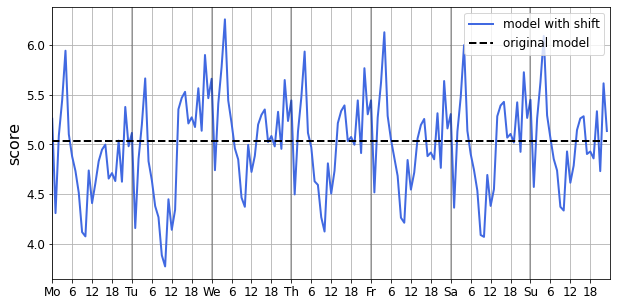

In [28]:
fig = plt.figure(figsize=(10,5))
#     plt.title(f'Average score of item of category "{k}" during week')
plt.plot(np.roll(bus_scores.mean(1),-7), color='royalblue', linewidth=2, label='model with shift')
plt.plot(np.ones_like(bus_scores.mean(1))*bus, color='k', linestyle='--', linewidth=2, label='original model')
plt.xticks(6*np.arange(4*7), ['Mo', 6, 12, 18, 'Tu', 6, 12, 18, 'We', 6, 12, 18, 'Th', 6, 12, 18, 'Fr', 6, 12, 18, 'Sa', 6, 12, 18, 'Su', 6, 12, 18], fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('score', fontsize=16)
plt.xlim(0, 24*7)
plt.grid(True)
for i in range(1, 7):
    plt.axvline(24*i, color='k', alpha=0.3)
plt.legend(fontsize=12)
plt.show()
fig.savefig(f'tisasrec_bus_scores_h,d.svg', format='svg', dpi=1400, bbox_inches='tight')

In [22]:
bus_ranks.mean(1)

array([4611.16620499, 4503.06001847, 4556.06094183, 3475.56140351,
       4564.12003693, 2872.56971376, 3379.59741459, 3566.72576177,
       5713.31486611, 3925.30286242, 3559.58079409, 2705.4598338 ,
       4138.37857802, 4596.62880886, 4684.92520776, 5357.52262235,
       6479.34533703, 6512.70360111, 5055.08587258, 5679.94275162,
       5254.77469991, 4893.42936288, 4642.26685134, 4484.5734072 ,
       5071.49953832, 4876.61218837, 4962.94921514, 4010.14589104,
       4666.78578024, 3277.31024931, 3599.47922438, 3743.11265005,
       5929.27977839, 4311.9455217 , 3965.95290859, 3169.47645429,
       4611.84025854, 4986.32871653, 5321.57156048, 5771.47553093,
       6882.56509695, 7046.44413666, 5604.30009234, 6173.81163435,
       5752.15604801, 3862.85133887, 3636.68421053, 3457.11819021,
       3973.91782087, 3755.46906741, 3902.79501385, 3059.30932595,
       3594.09325946, 2368.21052632, 2709.24192059, 2750.35826408,
       4679.84949215, 3290.6278855 , 2935.37488458, 2209.35826

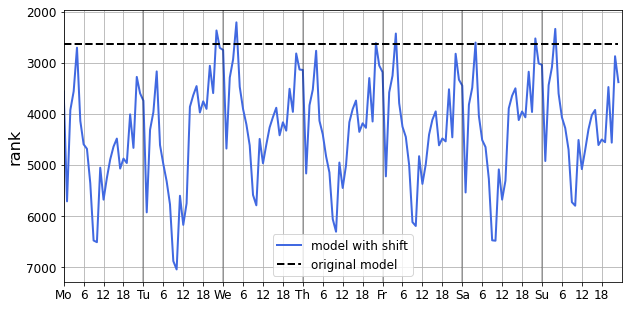

In [29]:
fig = plt.figure(figsize=(10,5))
#     plt.title(f'Average score of item of category "{k}" during week')
plt.plot(np.roll(bus_ranks.mean(1),-7), color='royalblue', linewidth=2, label='model with shift')
plt.plot(np.ones_like(bus_ranks.mean(1))*bus_rank, color='k', linestyle='--', linewidth=2, label='original model')
plt.xticks(6*np.arange(4*7), ['Mo', 6, 12, 18, 'Tu', 6, 12, 18, 'We', 6, 12, 18, 'Th', 6, 12, 18, 'Fr', 6, 12, 18, 'Sa', 6, 12, 18, 'Su', 6, 12, 18], fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('rank', fontsize=16)
plt.xlim(0, 24*7)
plt.grid(True)
for i in range(1, 7):
    plt.axvline(24*i, color='k', alpha=0.3)
plt.legend(fontsize=12)
plt.gca().invert_yaxis()
plt.show()
fig.savefig(f'tisasrec_bus_ranks_h,d.svg', format='svg', dpi=1400, bbox_inches='tight')

In [24]:
music_scores.mean(1)

array([3.7834221 , 3.82824824, 3.83781567, 4.27880096, 4.024768  ,
       4.65767072, 4.56464419, 4.33288614, 3.36483996, 4.05185271,
       4.14262147, 4.49633603, 3.70089372, 3.61892766, 3.39662581,
       3.27658196, 2.83589308, 2.87786882, 3.43212426, 3.16344188,
       3.37379356, 3.56261095, 3.69429309, 3.83814008, 3.5491544 ,
       3.61840675, 3.61805561, 4.00852257, 3.90757942, 4.43265749,
       4.41200893, 4.198789  , 3.22249958, 3.84335221, 3.93197292,
       4.25811422, 3.47877118, 3.41446508, 3.12240251, 3.0675918 ,
       2.63607012, 2.62461589, 3.17664933, 2.93249317, 3.13482216,
       4.03282675, 4.16306344, 4.31232997, 4.0401447 , 4.11566214,
       4.09881994, 4.47682588, 4.36591117, 4.89839925, 4.84642145,
       4.68402517, 3.72877947, 4.33333176, 4.43928195, 4.78515767,
       4.00519071, 3.92053161, 3.61527897, 3.57282235, 3.14437518,
       3.13239883, 3.66483783, 3.4385717 , 3.62088775, 3.81778075,
       3.93617778, 4.08307033, 3.80214111, 3.87648539, 3.85907

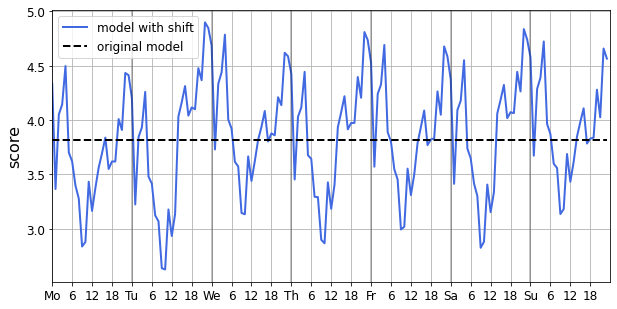

In [30]:
fig = plt.figure(figsize=(10,5))
#     plt.title(f'Average score of item of category "{k}" during week')
plt.plot(np.roll(music_scores.mean(1),-7), color='royalblue', linewidth=2, label='model with shift')
plt.plot(np.ones_like(music_scores.mean(1))*music, color='k', linestyle='--', linewidth=2, label='original model')
plt.xticks(6*np.arange(4*7), ['Mo', 6, 12, 18, 'Tu', 6, 12, 18, 'We', 6, 12, 18, 'Th', 6, 12, 18, 'Fr', 6, 12, 18, 'Sa', 6, 12, 18, 'Su', 6, 12, 18], fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('score', fontsize=16)
plt.xlim(0, 24*7)
plt.grid(True)
for i in range(1, 7):
    plt.axvline(24*i, color='k', alpha=0.3)
plt.legend(fontsize=12)
plt.show()
fig.savefig(f'tisasrec_music_scores_h,d.svg', format='svg', dpi=1400, bbox_inches='tight')

In [26]:
music_ranks.mean(1)

array([5679.89658356, 5537.61680517, 5484.8744229 , 4337.68790397,
       4903.17174515, 3496.49584488, 3510.25207756, 4177.92982456,
       6731.55771006, 4837.52262235, 4744.19852262, 3941.4099723 ,
       5695.73037858, 5983.64173592, 6448.96029548, 6914.36749769,
       8293.94182825, 8199.06832872, 6528.60757156, 7271.47368421,
       6657.78578024, 6244.75069252, 5926.87534626, 5588.7534626 ,
       6255.92705448, 6025.49307479, 6027.65835642, 4973.37950139,
       5153.3721145 , 3983.28070175, 3858.86057248, 4444.45060018,
       7091.6232687 , 5363.92243767, 5288.61403509, 4517.18928901,
       6288.01754386, 6525.44136657, 7157.93444137, 7479.75807941,
       8843.4312096 , 8900.60110803, 7204.91135734, 7900.21975993,
       7291.18559557, 5076.91320406, 4786.79039705, 4476.34256694,
       5047.93998153, 4816.34441367, 4847.44875346, 3923.66943675,
       4059.12834718, 3005.64912281, 2917.95660203, 3390.8079409 ,
       5659.02954755, 4190.42936288, 4065.74238227, 3322.70360

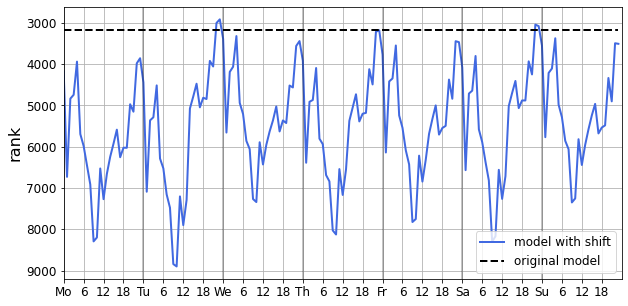

In [31]:
fig = plt.figure(figsize=(10,5))
#     plt.title(f'Average score of item of category "{k}" during week')
plt.plot(np.roll(music_ranks.mean(1),-7), color='royalblue', linewidth=2, label='model with shift')
plt.plot(np.ones_like(music_ranks.mean(1))*music_rank, color='k', linestyle='--', linewidth=2, label='original model')
plt.xticks(6*np.arange(4*7), ['Mo', 6, 12, 18, 'Tu', 6, 12, 18, 'We', 6, 12, 18, 'Th', 6, 12, 18, 'Fr', 6, 12, 18, 'Sa', 6, 12, 18, 'Su', 6, 12, 18], fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('rank', fontsize=16)
plt.xlim(0, 24*7)
plt.grid(True)
for i in range(1, 7):
    plt.axvline(24*i, color='k', alpha=0.3)
plt.legend(fontsize=12)
plt.gca().invert_yaxis()
plt.show()
fig.savefig(f'tisasrec_music_ranks_h,d.svg', format='svg', dpi=1400, bbox_inches='tight')

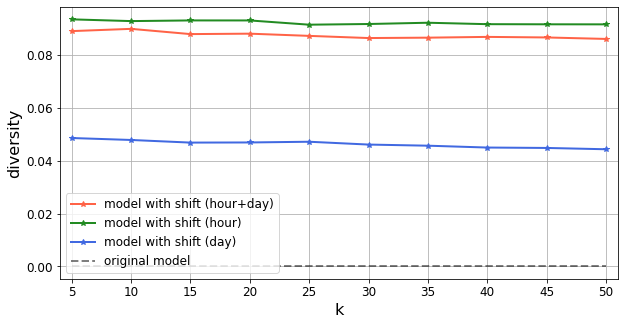

In [32]:
fig = plt.figure(figsize=(10,5))
# plt.title(f'Diversity of top-k recommendations given time context')
plt.plot(np.arange(5,55,5), hd_metrics.mean(1), color='tomato', marker='*', linewidth=2, label='model with shift (hour+day)')
plt.plot(np.arange(5,55,5), h_metrics.mean(1), color='forestgreen', marker='*', linewidth=2, label='model with shift (hour)')
plt.plot(np.arange(5,55,5), d_metrics.mean(1), color='royalblue', marker='*', linewidth=2, label='model with shift (day)')
plt.plot(np.arange(5,55,5), np.zeros_like(hd_metrics.mean(1)), color='k', linestyle='--', linewidth=2, alpha=0.5, label='original model')
plt.xticks(np.arange(5,55,5), fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('k', fontsize=16)
plt.ylabel('diversity', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.xlim(4,51)
plt.show()
fig.savefig(f'tisasrec_div.svg', format='svg', dpi=1400, bbox_inches='tight')

# Average score

In [83]:
items = {'Train Station': 1314,
 'Airport': 1512,
 'Bus Station': 2256,
 'Plaza': 2361,
 'Park': 903,
 'Road': 3994,
 'Subway': 4759,
 'Hotel': 3336,
 'Stadium': 752,
 'Neighborhood': 21908,
 'Music Venue': 183,
 'Bridge': 3669,
 'Electronics Store': 1653,
 'Other Great Outdoors': 24790,
 'Department Store': 1029,
 'Mall': 3300,
 'Home (private)': 27363,
 'Beach': 2855,
 'Gym / Fitness Center': 11169,
 'Movie Theater': 899,
 'Ferry': 3975,
 'Light Rail': 10381,
 'Chinese Restaurant': 15723,
 'Deli / Bodega': 34377,
 'Office': 1290,
 'Arcade': 25598,
 'Bar': 3238,
 'Gas Station / Garage': 12160,
 'Building': 1435,
 'General Travel': 24250,
 'Pizza Place': 19391,
 'College Academic Building': 11375,
 'Government Building': 8097,
 'Medical Center': 3734,
 'Coffee Shop': 5325,
 'City': 23545,
 'American Restaurant': 2197,
 'University': 6160,
 'Smoke Shop': 24874,
 'Residential Building (Apartment / Condo)': 34970,
 'Other Nightlife': 24284,
 'Library': 12176,
 'Community College': 7915,
 'Casino': 13446,
 'Food & Drink Shop': 9753,
 'Pool': 32973,
 'Bookstore': 5376,
 'Convention Center': 1296,
 'Market': 20384,
 'Campground': 30885,
 'River': 17955,
 'General Entertainment': 17712,
 'Caribbean Restaurant': 34359,
 'Moving Target': 35778,
 'Burger Joint': 951,
 'Art Museum': 1278,
 'Bank': 12689,
 'Sandwich Place': 397,
 'Furniture / Home Store': 3598,
 'Burrito Place': 24928,
 'Mobile Phone Shop': 17905,
 'French Restaurant': 411,
 'Arts & Crafts Store': 10182,
 'Salon / Barbershop': 24827,
 'Drugstore / Pharmacy': 5518,
 'School': 29759,
 'Post Office': 14981,
 'Playground': 20091,
 'Thai Restaurant': 9074,
 'Parking': 14687,
 'Tattoo Parlor': 18301,
 'Fast Food Restaurant': 22070,
 'Mexican Restaurant': 35301,
 'Event Space': 6842,
 'Garden': 29767,
 'Rest Area': 32033,
 'Miscellaneous Shop': 16020,
 'Nursery School': 33985,
 'Bakery': 10338,
 'German Restaurant': 24778,
 'Asian Restaurant': 1912,
 'Concert Hall': 2167,
 'Automotive Shop': 17553,
 'Beer Garden': 5016,
 'Sporting Goods Shop': 12272,
 'High School': 20555,
 'Athletic & Sport': 9290,
 'Harbor / Marina': 12567,
 'Italian Restaurant': 11467,
 'Cafй': 10882,
 'Recycling Facility': 8540,
 'Molecular Gastronomy Restaurant': 30727,
 'Arts & Entertainment': 26271,
 'Donut Shop': 15592,
 'Clothing Store': 22690,
 'Food Truck': 6807,
 'Convenience Store': 37313,
 'Ramen /  Noodle House': 4130,
 'Theater': 7828,
 'Funeral Home': 34273,
 'Church': 9323,
 'Paper / Office Supplies Store': 10354,
 'Science Museum': 1316,
 'Housing Development': 13302,
 'Bagel Shop': 9652,
 'Gastropub': 10143,
 'General College & University': 23186,
 'Student Center': 21774,
 'Law School': 6364,
 'Shrine': 32709,
 'Diner': 276,
 'Laundry Service': 25082,
 'Bowling Alley': 3465,
 'Hot Dog Joint': 576,
 'Flea Market': 26842,
 'Hardware Store': 3503,
 'Outdoors & Recreation': 30212,
 'Pet Store': 4137,
 'Historic Site': 3236,
 'Breakfast Spot': 23147,
 'BBQ Joint': 18191,
 'Sushi Restaurant': 11625,
 'Performing Arts Venue': 32150,
 'Salad Place': 7150,
 'Candy Store': 3276,
 'Scenic Lookout': 26596,
 'Cuban Restaurant': 14585,
 'Seafood Restaurant': 8056,
 'Racetrack': 10603,
 'Ice Cream Shop': 2602,
 'Restaurant': 4502,
 'Fried Chicken Joint': 21615,
 'Dessert Shop': 1695,
 'Thrift / Vintage Store': 3723,
 'Food': 30100,
 'Eastern European Restaurant': 626,
 'Snack Place': 30462,
 'Cemetery': 37696,
 'Elementary School': 21898,
 'Travel & Transport': 30382,
 'Toy / Game Store': 4348,
 'College & University': 24097,
 'Trade School': 29408,
 'Sculpture Garden': 21954,
 'Latin American Restaurant': 27961,
 'Taxi': 4739,
 'Brewery': 336,
 'Hobby Shop': 196,
 'Soup Place': 3858,
 'Museum': 34049,
 'Tanning Salon': 15169,
 'Cupcake Shop': 23198,
 'Synagogue': 11476,
 'Vietnamese Restaurant': 23292,
 'Art Gallery': 20857,
 'Temple': 35357,
 'Pool Hall': 948,
 'Korean Restaurant': 908,
 'Spa / Massage': 22605,
 'Factory': 33390,
 'Bridal Shop': 11378,
 'Middle School': 9935,
 'Southern / Soul Food Restaurant': 3308,
 'Falafel Restaurant': 3195,
 'Garden Center': 35468,
 'Animal Shelter': 33737,
 'Travel Lounge': 36948,
 'Zoo': 1663,
 'Middle Eastern Restaurant': 2476,
 'Design Studio': 35400,
 'Comedy Club': 1209,
 'Vegetarian / Vegan Restaurant': 8103,
 'Wings Joint': 7605,
 'Taco Place': 1378,
 'Spanish Restaurant': 23878,
 'Tea Room': 11260,
 'College Stadium': 22475,
 'Spiritual Center': 25228,
 'Steakhouse': 33023,
 'Brazilian Restaurant': 16256,
 'Australian Restaurant': 29665,
 'Professional & Other Places': 29815,
 'Malaysian Restaurant': 522,
 'Dim Sum Restaurant': 717,
 'Japanese Restaurant': 1055,
 'Mediterranean Restaurant': 16623,
 'Cosmetics Shop': 21112,
 'Financial or Legal Service': 1379,
 'Camera Store': 7105,
 'Filipino Restaurant': 28539,
 'Cajun / Creole Restaurant': 990,
 'Indian Restaurant': 7748,
 'Fair': 29967,
 'Music Store': 7997,
 'Tapas Restaurant': 23328,
 'Jewelry Store': 2027,
 'Mac & Cheese Joint': 1668,
 'Swiss Restaurant': 2396,
 'Military Base': 31145,
 'Antique Shop': 1349,
 'Medical School': 18717,
 'Dumpling Restaurant': 2986,
 'Rental Car Location': 34327,
 'South American Restaurant': 6393,
 'Aquarium': 2939,
 'Gift Shop': 20955,
 'African Restaurant': 34488,
 'Mosque': 20762,
 'Video Game Store': 1509,
 'Nail Salon': 19534,
 'Bike Shop': 16833,
 'Storage Facility': 17605,
 'Car Dealership': 12012,
 'Turkish Restaurant': 2938,
 'Car Wash': 19818,
 'Scandinavian Restaurant': 32812,
 'College Theater': 27179,
 'History Museum': 1794,
 'Arepa Restaurant': 1047,
 'Fish & Chips Shop': 303,
 'Flower Shop': 17744,
 'Argentinian Restaurant': 2580,
 'Greek Restaurant': 1572,
 'Video Store': 28482,
 'Nightlife Spot': 28074,
 'Peruvian Restaurant': 28984,
 'Shop & Service': 18617,
 'Record Shop': 62,
 'Board Shop': 805,
 'Winery': 26566,
 'Moroccan Restaurant': 33800,
 'Public Art': 14300,
 'Distillery': 28219,
 'Planetarium': 13013,
 'Embassy / Consulate': 11398,
 'Bike Rental / Bike Share': 34370,
 'Gaming Cafe': 33355,
 'Ethiopian Restaurant': 3123,
 'Sorority House': 17190,
 'Internet Cafe': 24861,
 'Fraternity House': 19085,
 'Ski Area': 24045,
 'Portuguese Restaurant': 15276,
 'Gluten-free Restaurant': 27437,
 'Newsstand': 13176,
 'Motorcycle Shop': 9178,
 'Castle': 4086,
 'Afghan Restaurant': 4766,
 'Photography Lab': 3452,
 'Pet Service': 5286,
 'Music School': 35187}

In [85]:
count_items = {'Train Station': 1147,
 'Airport': 687,
 'Bus Station': 562,
 'Plaza': 472,
 'Park': 442,
 'Road': 407,
 'Subway': 322,
 'Hotel': 272,
 'Stadium': 266,
 'Neighborhood': 224,
 'Music Venue': 212,
 'Bridge': 211,
 'Electronics Store': 208,
 'Other Great Outdoors': 205,
 'Department Store': 188,
 'Mall': 187,
 'Home (private)': 182,
 'Beach': 181,
 'Gym / Fitness Center': 166,
 'Movie Theater': 160,
 'Ferry': 159,
 'Light Rail': 156,
 'Chinese Restaurant': 155,
 'Deli / Bodega': 152,
 'Office': 148,
 'Arcade': 146,
 'Bar': 145,
 'Gas Station / Garage': 143,
 'Building': 140,
 'General Travel': 135,
 'Pizza Place': 132,
 'College Academic Building': 132,
 'Government Building': 129,
 'Medical Center': 122,
 'Coffee Shop': 119,
 'City': 118,
 'American Restaurant': 115,
 'University': 110,
 'Smoke Shop': 110,
 'Residential Building (Apartment / Condo)': 103,
 'Other Nightlife': 103,
 'Library': 97,
 'Community College': 95,
 'Casino': 94,
 'Food & Drink Shop': 94,
 'Pool': 93,
 'Bookstore': 91,
 'Convention Center': 90,
 'Market': 88,
 'Campground': 86,
 'River': 85,
 'General Entertainment': 81,
 'Caribbean Restaurant': 80,
 'Moving Target': 78,
 'Burger Joint': 77,
 'Art Museum': 76,
 'Bank': 75,
 'Sandwich Place': 75,
 'Furniture / Home Store': 74,
 'Burrito Place': 73,
 'Mobile Phone Shop': 72,
 'French Restaurant': 72,
 'Arts & Crafts Store': 71,
 'Salon / Barbershop': 70,
 'Drugstore / Pharmacy': 68,
 'School': 68,
 'Post Office': 68,
 'Playground': 67,
 'Thai Restaurant': 67,
 'Parking': 66,
 'Tattoo Parlor': 66,
 'Fast Food Restaurant': 64,
 'Mexican Restaurant': 63,
 'Event Space': 63,
 'Garden': 61,
 'Rest Area': 61,
 'Miscellaneous Shop': 61,
 'Nursery School': 61,
 'Bakery': 60,
 'German Restaurant': 59,
 'Asian Restaurant': 58,
 'Concert Hall': 58,
 'Automotive Shop': 57,
 'Beer Garden': 57,
 'Sporting Goods Shop': 56,
 'High School': 55,
 'Athletic & Sport': 55,
 'Harbor / Marina': 55,
 'Italian Restaurant': 53,
 'Cafй': 53,
 'Recycling Facility': 51,
 'Molecular Gastronomy Restaurant': 50,
 'Arts & Entertainment': 50,
 'Donut Shop': 50,
 'Clothing Store': 50,
 'Food Truck': 49,
 'Convenience Store': 49,
 'Ramen /  Noodle House': 49,
 'Theater': 48,
 'Funeral Home': 47,
 'Church': 46,
 'Paper / Office Supplies Store': 46,
 'Science Museum': 45,
 'Housing Development': 45,
 'Bagel Shop': 44,
 'Gastropub': 44,
 'General College & University': 44,
 'Student Center': 44,
 'Law School': 43,
 'Shrine': 43,
 'Diner': 42,
 'Laundry Service': 42,
 'Bowling Alley': 41,
 'Hot Dog Joint': 41,
 'Flea Market': 41,
 'Hardware Store': 41,
 'Outdoors & Recreation': 40,
 'Pet Store': 40,
 'Historic Site': 39,
 'Breakfast Spot': 39,
 'BBQ Joint': 39,
 'Sushi Restaurant': 39,
 'Performing Arts Venue': 38,
 'Salad Place': 37,
 'Candy Store': 37,
 'Scenic Lookout': 37,
 'Cuban Restaurant': 37,
 'Seafood Restaurant': 37,
 'Racetrack': 36,
 'Ice Cream Shop': 36,
 'Restaurant': 36,
 'Fried Chicken Joint': 36,
 'Dessert Shop': 35,
 'Thrift / Vintage Store': 34,
 'Food': 34,
 'Eastern European Restaurant': 34,
 'Snack Place': 34,
 'Cemetery': 34,
 'Elementary School': 33,
 'Travel & Transport': 32,
 'Toy / Game Store': 32,
 'College & University': 31,
 'Trade School': 31,
 'Sculpture Garden': 31,
 'Latin American Restaurant': 31,
 'Taxi': 30,
 'Brewery': 29,
 'Hobby Shop': 28,
 'Soup Place': 28,
 'Museum': 27,
 'Tanning Salon': 26,
 'Cupcake Shop': 26,
 'Synagogue': 25,
 'Vietnamese Restaurant': 25,
 'Art Gallery': 24,
 'Temple': 23,
 'Pool Hall': 23,
 'Korean Restaurant': 22,
 'Spa / Massage': 22,
 'Factory': 22,
 'Bridal Shop': 21,
 'Middle School': 21,
 'Southern / Soul Food Restaurant': 21,
 'Falafel Restaurant': 21,
 'Garden Center': 21,
 'Animal Shelter': 21,
 'Travel Lounge': 19,
 'Zoo': 19,
 'Middle Eastern Restaurant': 19,
 'Design Studio': 19,
 'Comedy Club': 18,
 'Vegetarian / Vegan Restaurant': 18,
 'Wings Joint': 18,
 'Taco Place': 18,
 'Spanish Restaurant': 18,
 'Tea Room': 17,
 'College Stadium': 17,
 'Spiritual Center': 17,
 'Steakhouse': 17,
 'Brazilian Restaurant': 16,
 'Australian Restaurant': 15,
 'Professional & Other Places': 15,
 'Malaysian Restaurant': 15,
 'Dim Sum Restaurant': 14,
 'Japanese Restaurant': 14,
 'Mediterranean Restaurant': 14,
 'Cosmetics Shop': 14,
 'Financial or Legal Service': 14,
 'Camera Store': 14,
 'Filipino Restaurant': 13,
 'Cajun / Creole Restaurant': 13,
 'Indian Restaurant': 13,
 'Fair': 13,
 'Music Store': 13,
 'Tapas Restaurant': 12,
 'Jewelry Store': 12,
 'Mac & Cheese Joint': 12,
 'Swiss Restaurant': 12,
 'Military Base': 11,
 'Antique Shop': 10,
 'Medical School': 10,
 'Dumpling Restaurant': 10,
 'Rental Car Location': 10,
 'South American Restaurant': 10,
 'Aquarium': 10,
 'Gift Shop': 10,
 'African Restaurant': 10,
 'Mosque': 9,
 'Video Game Store': 9,
 'Nail Salon': 9,
 'Bike Shop': 9,
 'Storage Facility': 8,
 'Car Dealership': 8,
 'Turkish Restaurant': 8,
 'Car Wash': 8,
 'Scandinavian Restaurant': 8,
 'College Theater': 8,
 'History Museum': 8,
 'Arepa Restaurant': 7,
 'Fish & Chips Shop': 7,
 'Flower Shop': 7,
 'Argentinian Restaurant': 7,
 'Greek Restaurant': 7,
 'Video Store': 6,
 'Nightlife Spot': 6,
 'Peruvian Restaurant': 6,
 'Shop & Service': 6,
 'Record Shop': 6,
 'Board Shop': 5,
 'Winery': 5,
 'Moroccan Restaurant': 5,
 'Public Art': 5,
 'Distillery': 4,
 'Planetarium': 4,
 'Embassy / Consulate': 4,
 'Bike Rental / Bike Share': 4,
 'Gaming Cafe': 4,
 'Ethiopian Restaurant': 4,
 'Sorority House': 4,
 'Internet Cafe': 3,
 'Fraternity House': 3,
 'Ski Area': 3,
 'Portuguese Restaurant': 3,
 'Gluten-free Restaurant': 2,
 'Newsstand': 2,
 'Motorcycle Shop': 2,
 'Castle': 2,
 'Afghan Restaurant': 2,
 'Photography Lab': 1,
 'Pet Service': 1,
 'Music School': 1}

## GRU4Rec

In [38]:
# parser
parser = argparse.ArgumentParser(description='')
parser.add_argument('--gpu', type=str, default='', help='Set CUDA_VISIBLE_DEVICES, default for CPU only')
parser.add_argument('--random_seed', type=int, default=0, help='Random seed of numpy and pytorch')
parser.add_argument('--history_max', type=int, default=20, help='Maximum length of history.')
parser.add_argument('--dropout', type=float, default=0, help='Dropout probability for each deep layer')
parser.add_argument('--test_all', type=int, default=0, help='Whether testing on all the items.')
parser.add_argument('--emb_size', type=int, default=64, help='Size of embedding vectors.')
parser.add_argument('--hidden_size', type=int, default=100, help='Size of hidden vectors in GRU.')
parser.add_argument('--time_units', type=str, default='h,d', help='Time units for creating time embeddings')
parser.add_argument('--buffer', type=int, default=1, help='Whether to buffer feed dicts for dev/test')
parser.add_argument('--num_neg', type=int, default=1, help='The number of negative items during training.')
args, extras = parser.parse_known_args()
args.device = torch.device('cpu')
args.model_path = '/'

In [39]:
args

Namespace(gpu='', random_seed=0, history_max=20, dropout=0, test_all=0, emb_size=64, hidden_size=100, time_units='h,d', buffer=1, num_neg=1, device=device(type='cpu'), model_path='/')

In [78]:
# orig_model = GRU4Rec(args, orig_corpus)

In [45]:
# orig_model

In [46]:
# original
# orig_model.load_state_dict(torch.load('../model/GRU4Rec_shift/GRU4Rec__4Square_NYC__0__lr=0.001__l2=0.0001__emb_size=64__hidden_size=100.pt', map_location=args.device))

### hour, day

In [86]:
args.prediction_time = 'hour,day'
model = GRU4Rec_shift(args, orig_corpus)

In [87]:
model

GRU4Rec(
  (i_embeddings): Embedding(38334, 64)
  (h_shift_embeddings): Embedding(25, 64)
  (d_shift_embeddings): Embedding(8, 64)
  (m_shift_embeddings): Embedding(13, 64)
  (rnn): GRU(128, 100, batch_first=True)
  (out): Linear(in_features=100, out_features=64, bias=True)
)

In [88]:
# h,d
model.load_state_dict(torch.load('../model/GRU4Rec_shift/GRU4Rec__4Square_NYC__0__lr=0.001__l2=0.0001__emb_size=64__hidden_size=100_h,d.pt', map_location=args.device))

<All keys matched successfully>

Train Station 	 item 1314 	 # check-ins: 1147


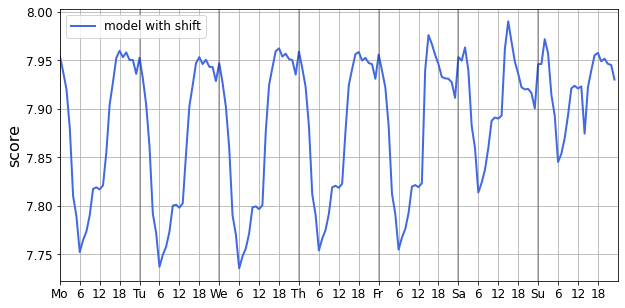

Airport 	 item 1512 	 # check-ins: 687


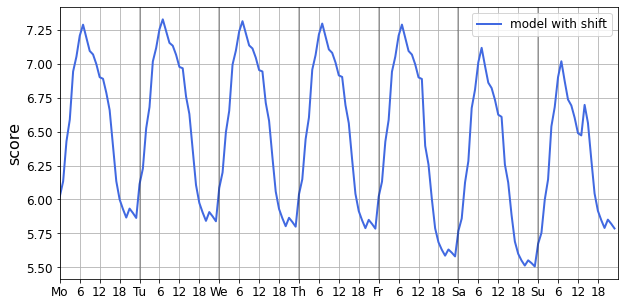

Bus Station 	 item 2256 	 # check-ins: 562


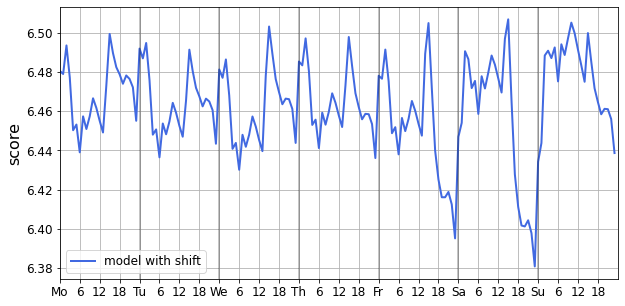

Plaza 	 item 2361 	 # check-ins: 472


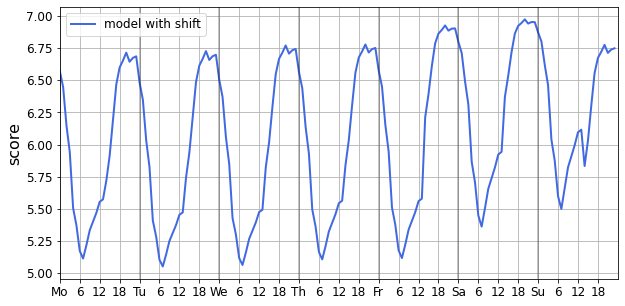

Park 	 item 903 	 # check-ins: 442


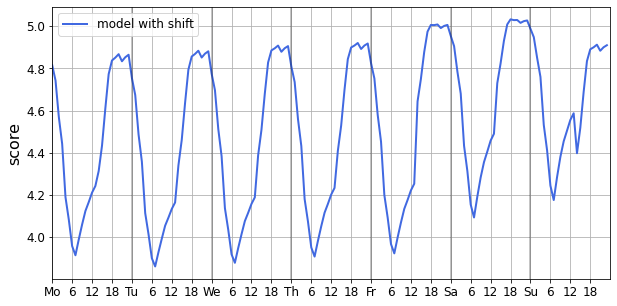

Road 	 item 3994 	 # check-ins: 407


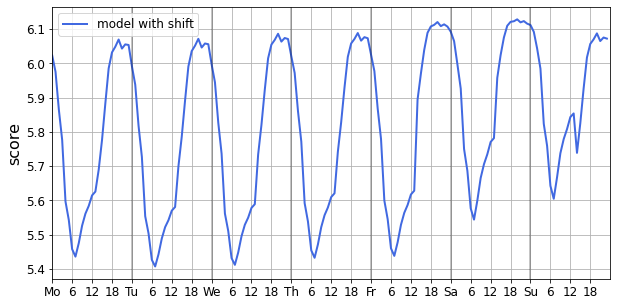

Subway 	 item 4759 	 # check-ins: 322


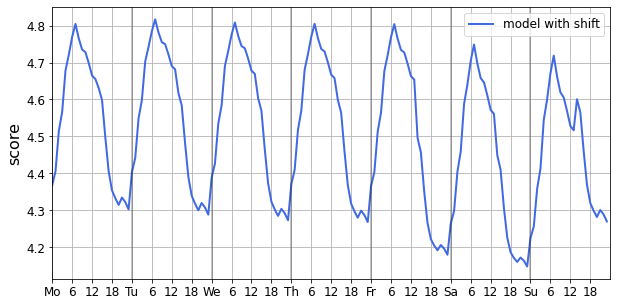

Hotel 	 item 3336 	 # check-ins: 272


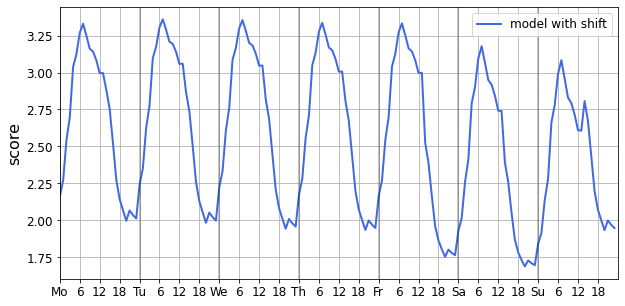

Stadium 	 item 752 	 # check-ins: 266


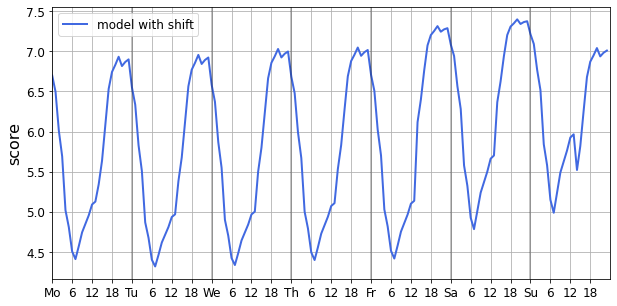

Neighborhood 	 item 21908 	 # check-ins: 224


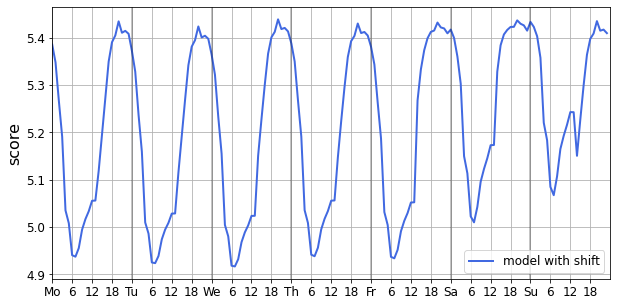

Music Venue 	 item 183 	 # check-ins: 212


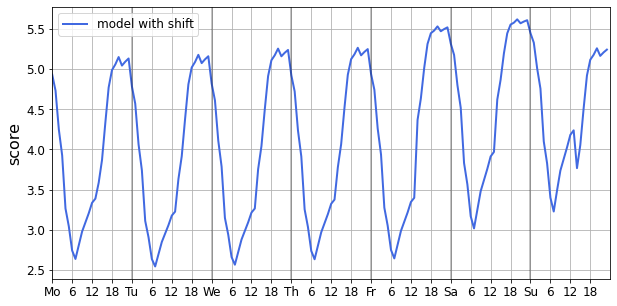

Bridge 	 item 3669 	 # check-ins: 211


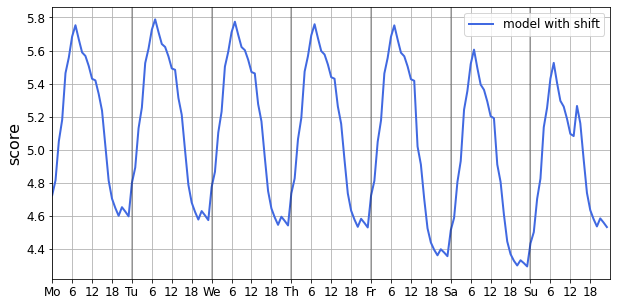

Electronics Store 	 item 1653 	 # check-ins: 208


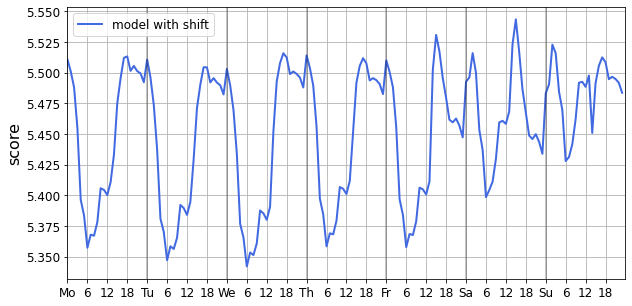

Other Great Outdoors 	 item 24790 	 # check-ins: 205


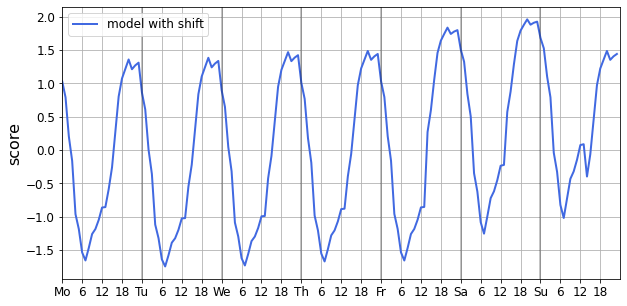

Department Store 	 item 1029 	 # check-ins: 188


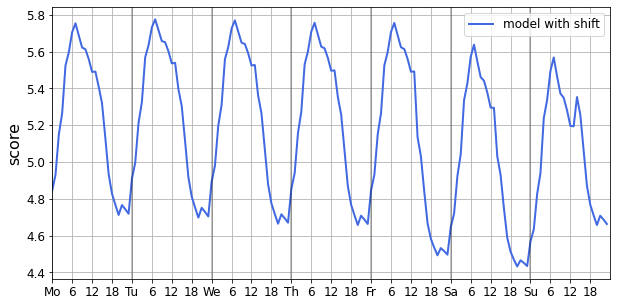

Mall 	 item 3300 	 # check-ins: 187


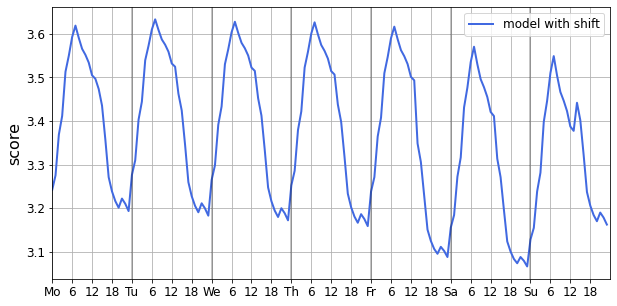

Home (private) 	 item 27363 	 # check-ins: 182


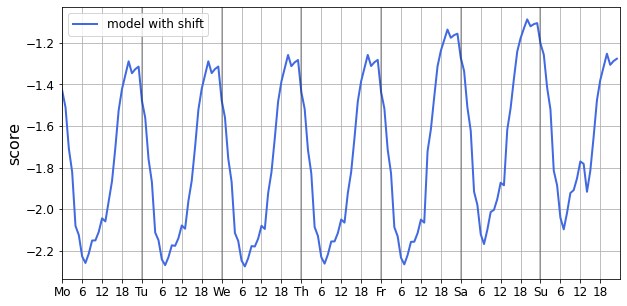

Beach 	 item 2855 	 # check-ins: 181


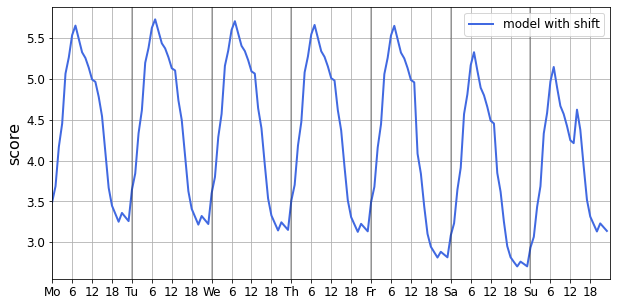

Gym / Fitness Center 	 item 11169 	 # check-ins: 166


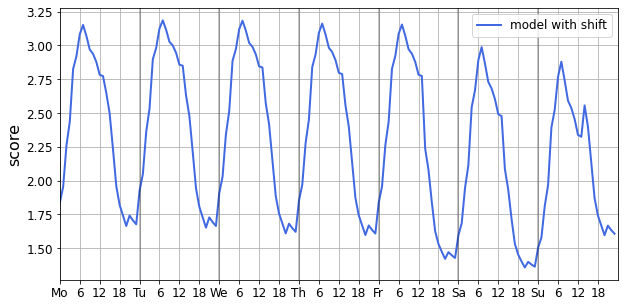

Movie Theater 	 item 899 	 # check-ins: 160


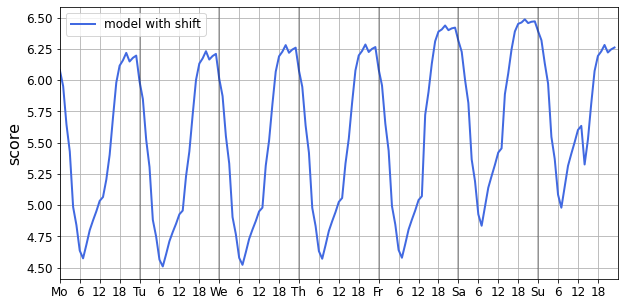

Ferry 	 item 3975 	 # check-ins: 159


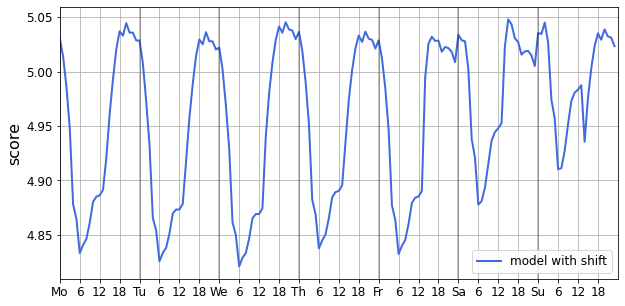

Light Rail 	 item 10381 	 # check-ins: 156


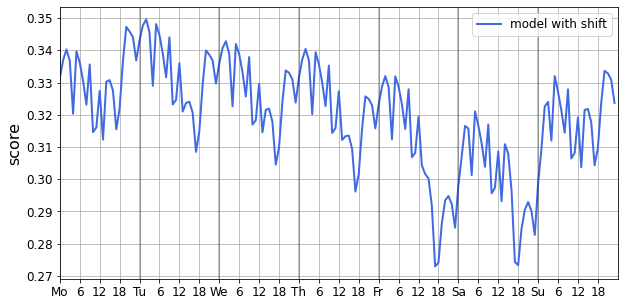

Chinese Restaurant 	 item 15723 	 # check-ins: 155


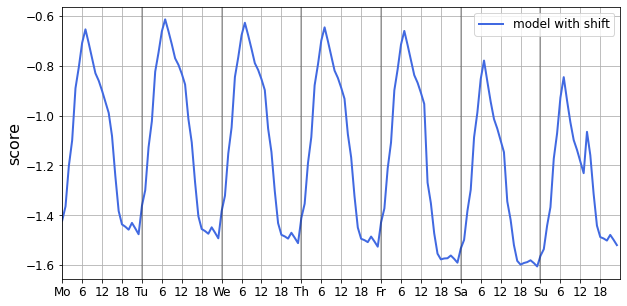

Deli / Bodega 	 item 34377 	 # check-ins: 152


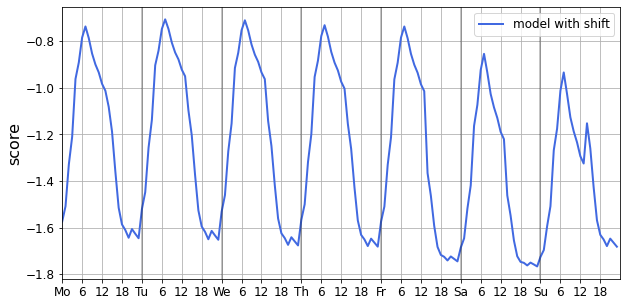

Office 	 item 1290 	 # check-ins: 148


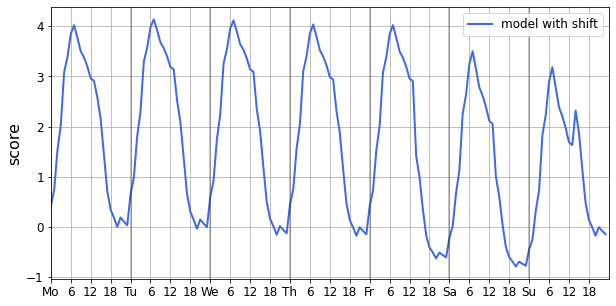

Arcade 	 item 25598 	 # check-ins: 146


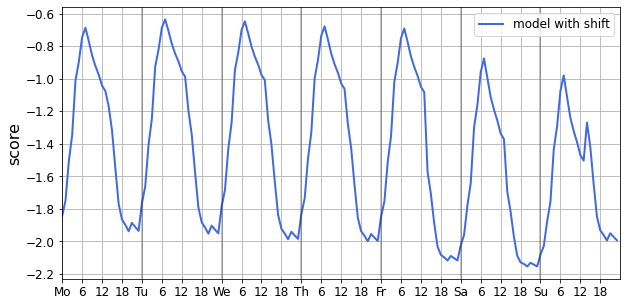

Bar 	 item 3238 	 # check-ins: 145


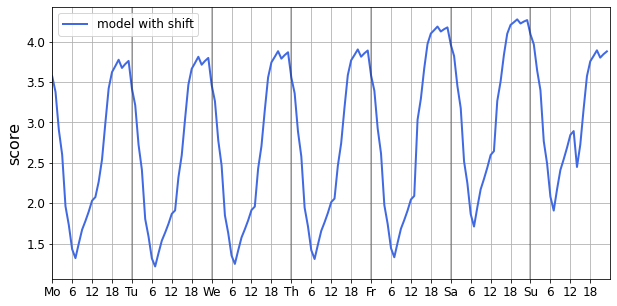

Gas Station / Garage 	 item 12160 	 # check-ins: 143


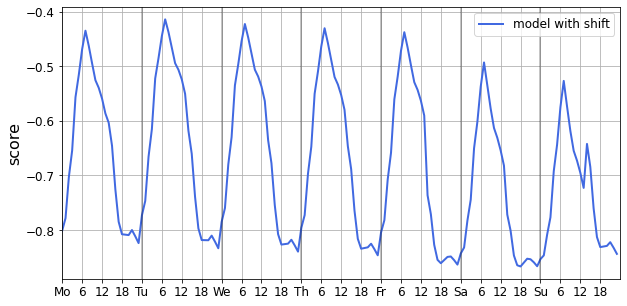

Building 	 item 1435 	 # check-ins: 140


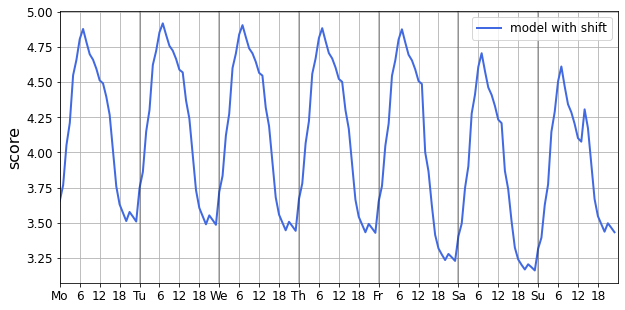

General Travel 	 item 24250 	 # check-ins: 135


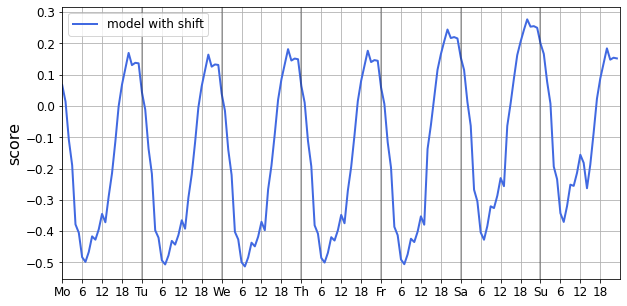

Pizza Place 	 item 19391 	 # check-ins: 132


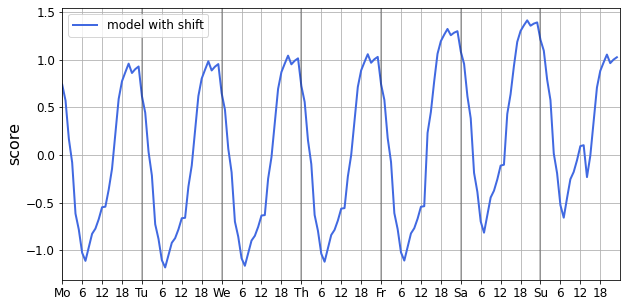

College Academic Building 	 item 11375 	 # check-ins: 132


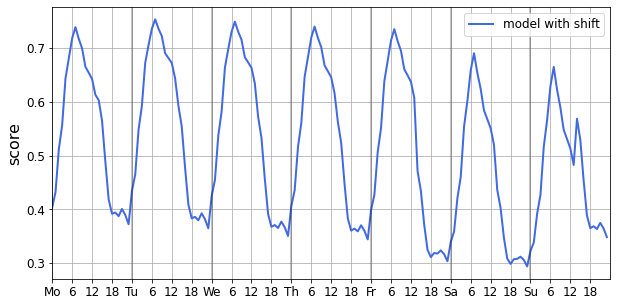

Government Building 	 item 8097 	 # check-ins: 129


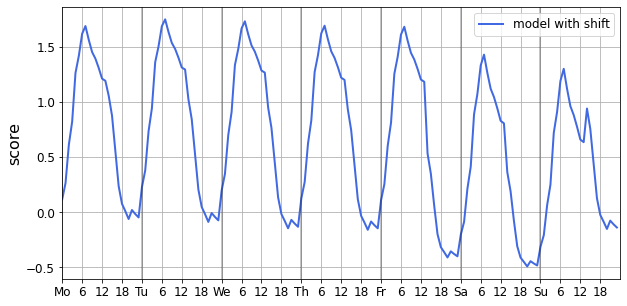

Medical Center 	 item 3734 	 # check-ins: 122


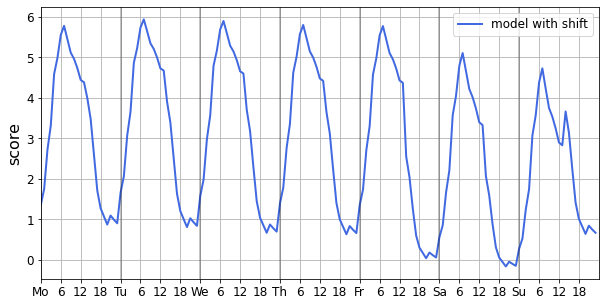

Coffee Shop 	 item 5325 	 # check-ins: 119


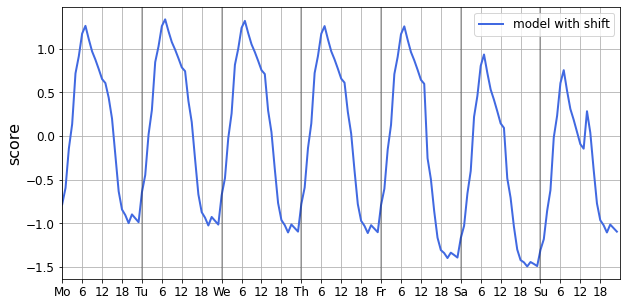

City 	 item 23545 	 # check-ins: 118


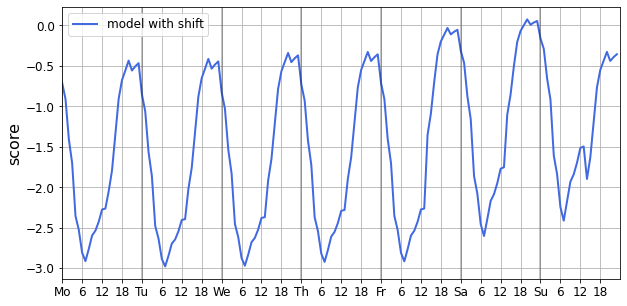

American Restaurant 	 item 2197 	 # check-ins: 115


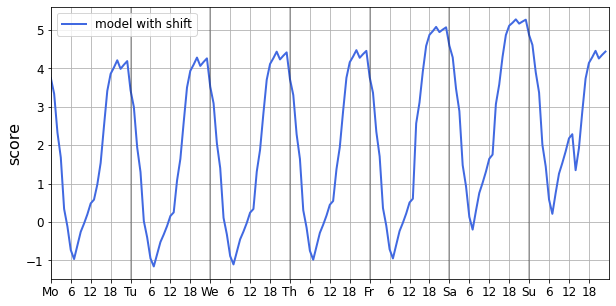

University 	 item 6160 	 # check-ins: 110


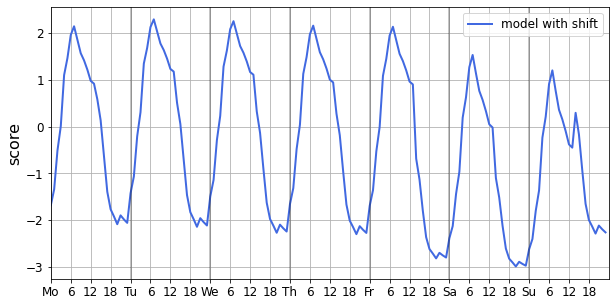

Smoke Shop 	 item 24874 	 # check-ins: 110


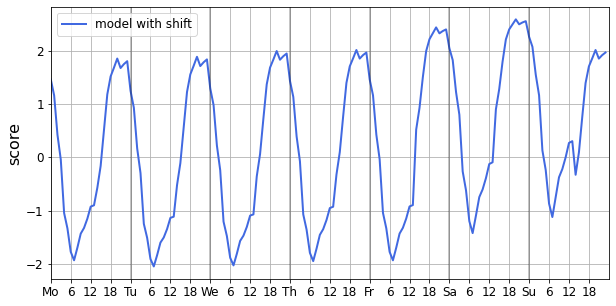

Residential Building (Apartment / Condo) 	 item 34970 	 # check-ins: 103


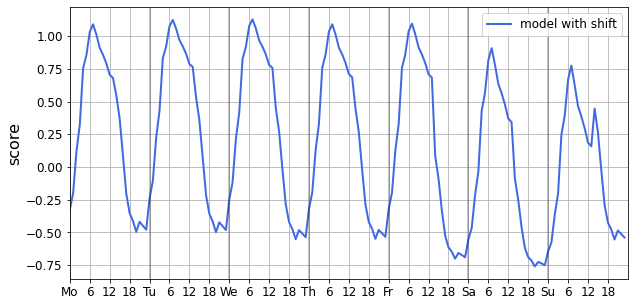

Other Nightlife 	 item 24284 	 # check-ins: 103


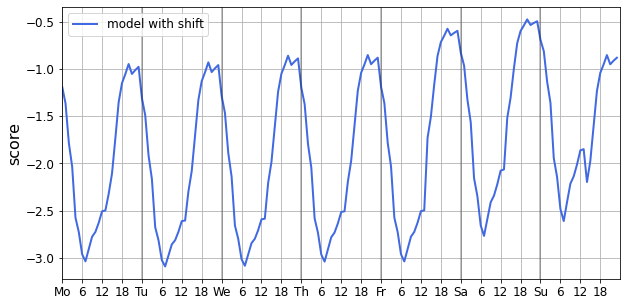

Library 	 item 12176 	 # check-ins: 97


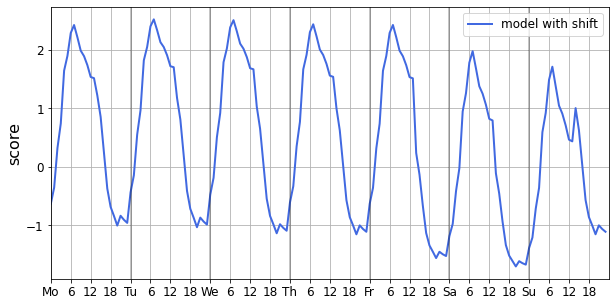

Community College 	 item 7915 	 # check-ins: 95


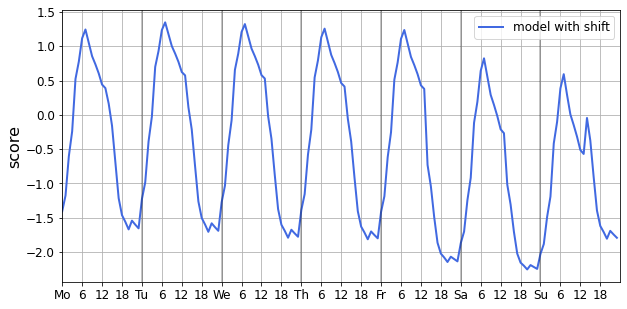

Casino 	 item 13446 	 # check-ins: 94


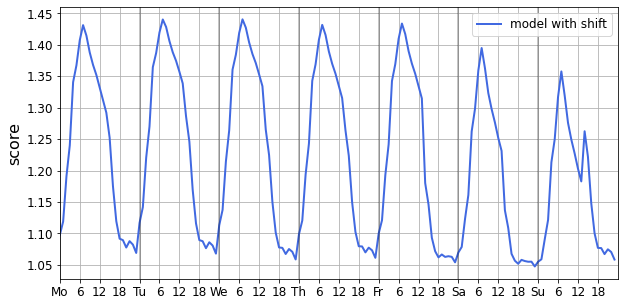

Food & Drink Shop 	 item 9753 	 # check-ins: 94


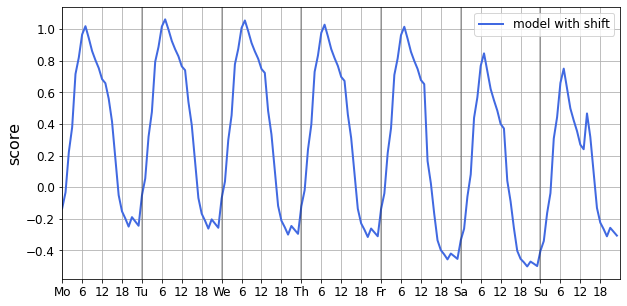

Pool 	 item 32973 	 # check-ins: 93


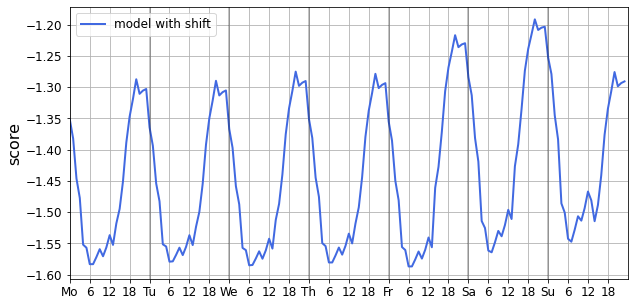

Bookstore 	 item 5376 	 # check-ins: 91


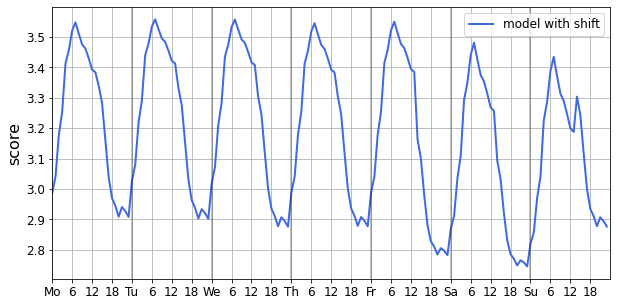

Convention Center 	 item 1296 	 # check-ins: 90


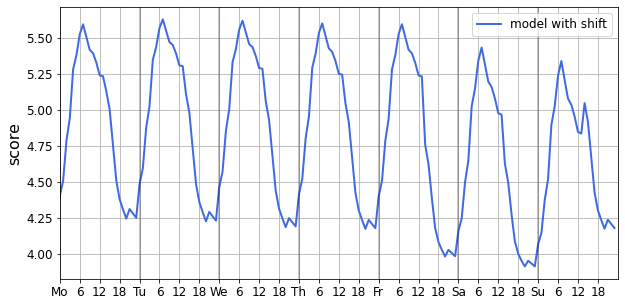

Market 	 item 20384 	 # check-ins: 88


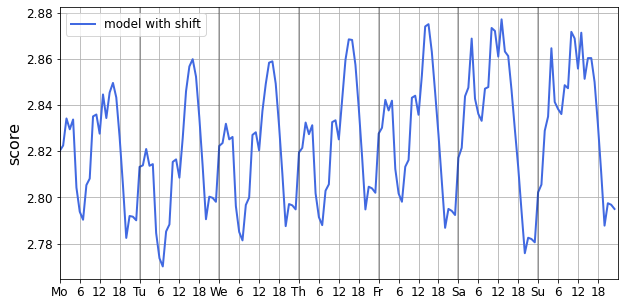

Campground 	 item 30885 	 # check-ins: 86


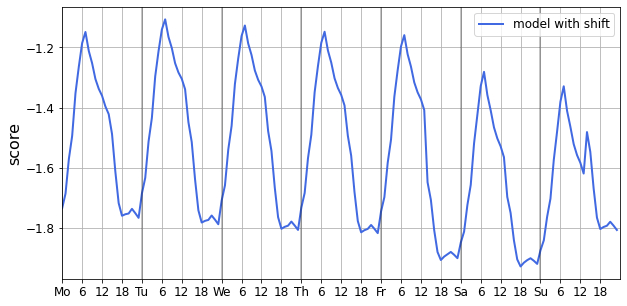

River 	 item 17955 	 # check-ins: 85


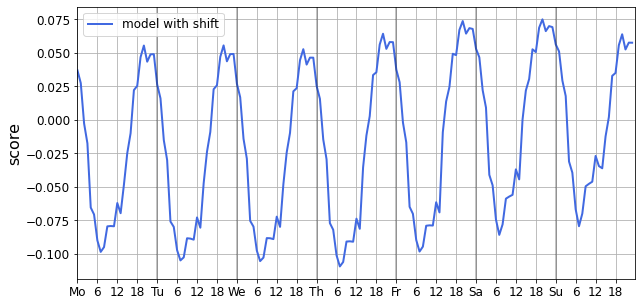

General Entertainment 	 item 17712 	 # check-ins: 81


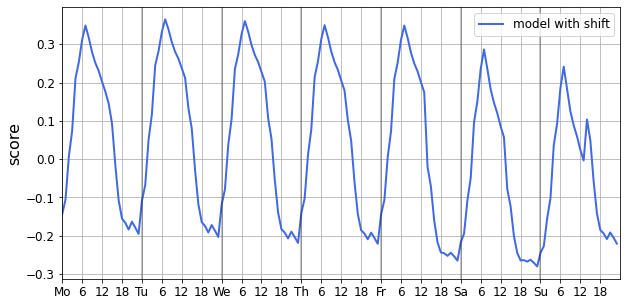

Caribbean Restaurant 	 item 34359 	 # check-ins: 80


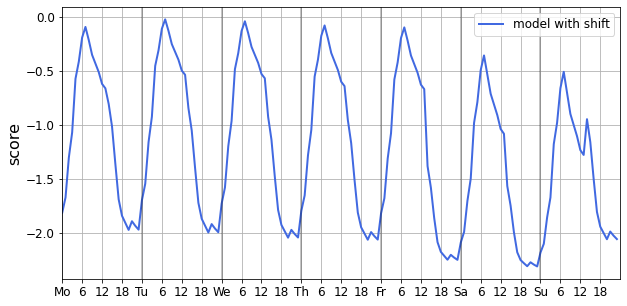

Moving Target 	 item 35778 	 # check-ins: 78


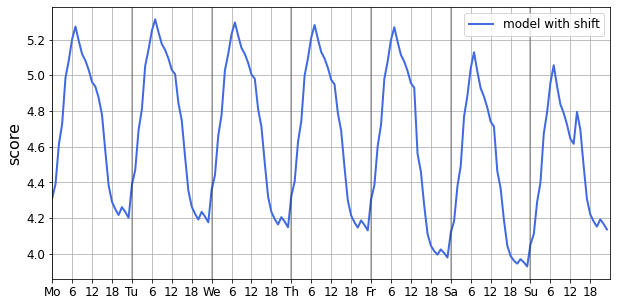

Burger Joint 	 item 951 	 # check-ins: 77


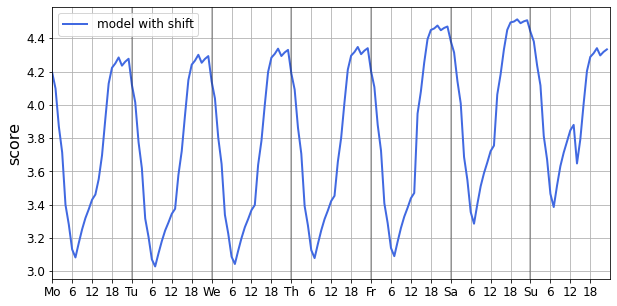

Art Museum 	 item 1278 	 # check-ins: 76


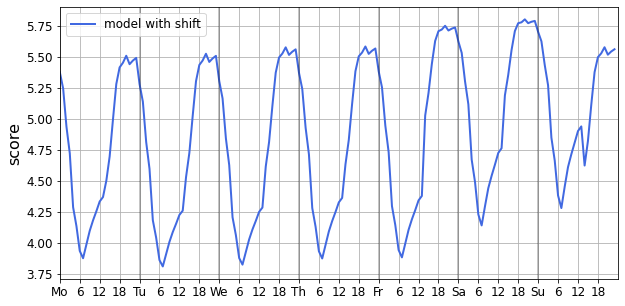

Bank 	 item 12689 	 # check-ins: 75


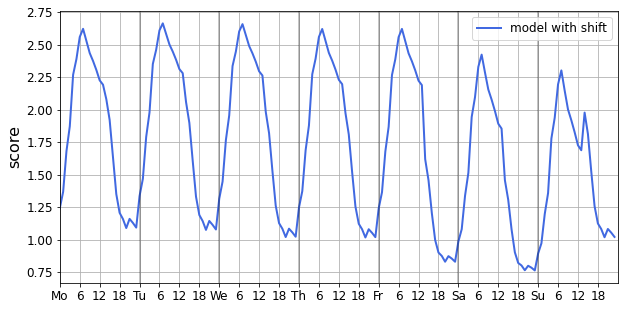

Sandwich Place 	 item 397 	 # check-ins: 75


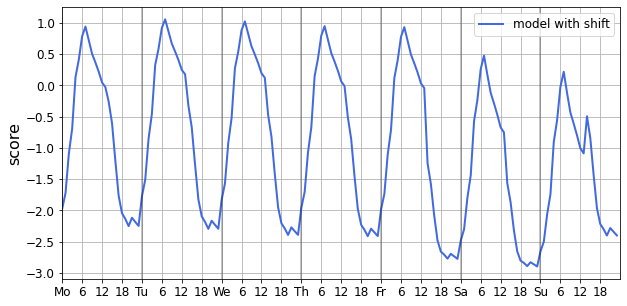

Furniture / Home Store 	 item 3598 	 # check-ins: 74


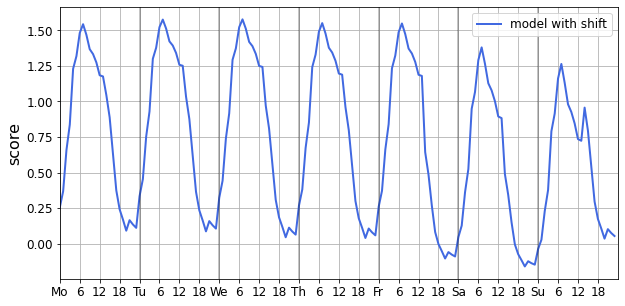

Burrito Place 	 item 24928 	 # check-ins: 73


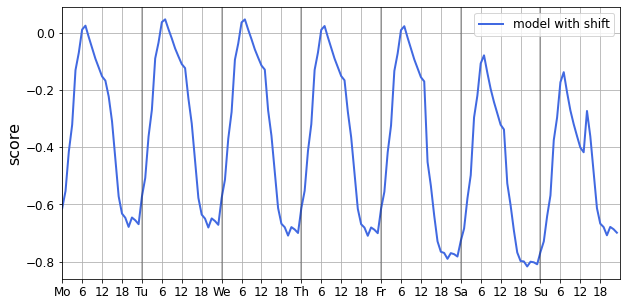

Mobile Phone Shop 	 item 17905 	 # check-ins: 72


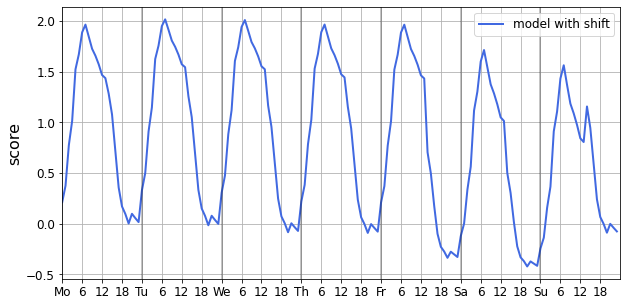

French Restaurant 	 item 411 	 # check-ins: 72


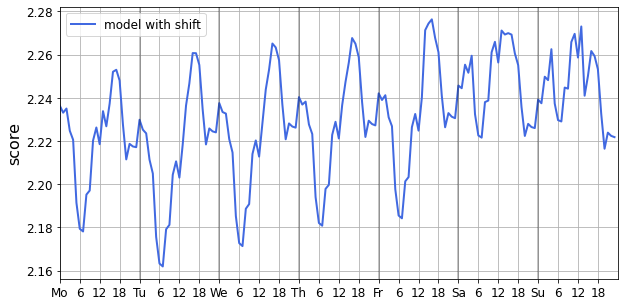

Arts & Crafts Store 	 item 10182 	 # check-ins: 71


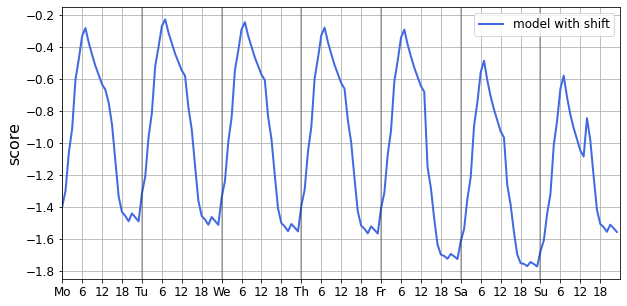

Salon / Barbershop 	 item 24827 	 # check-ins: 70


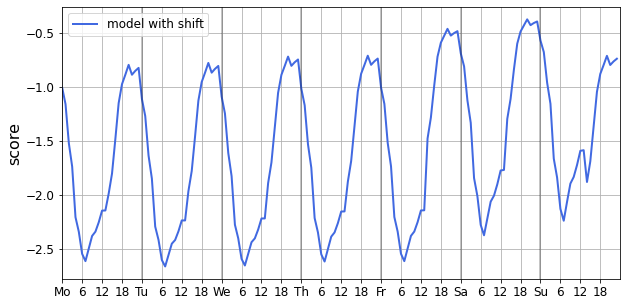

Drugstore / Pharmacy 	 item 5518 	 # check-ins: 68


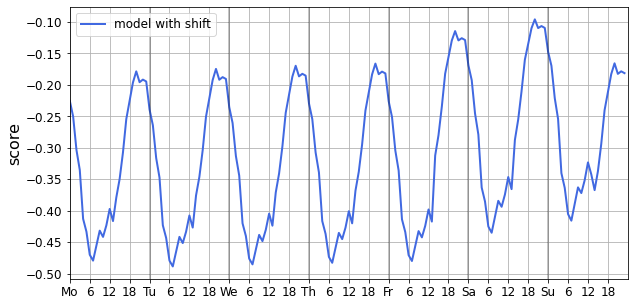

School 	 item 29759 	 # check-ins: 68


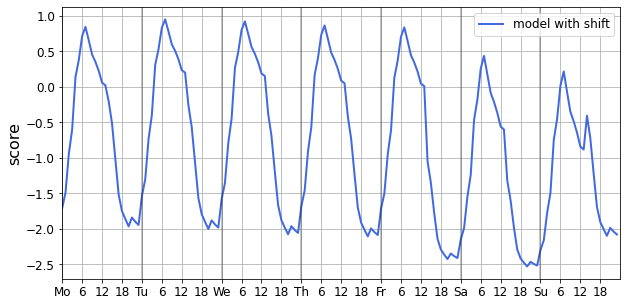

Post Office 	 item 14981 	 # check-ins: 68


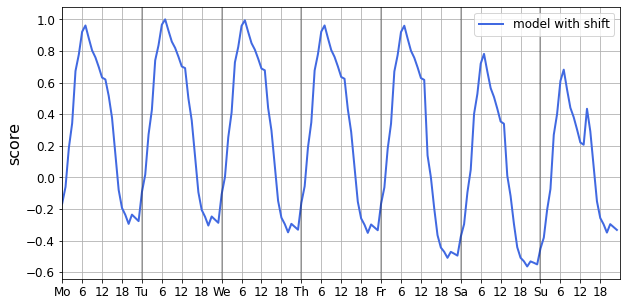

Playground 	 item 20091 	 # check-ins: 67


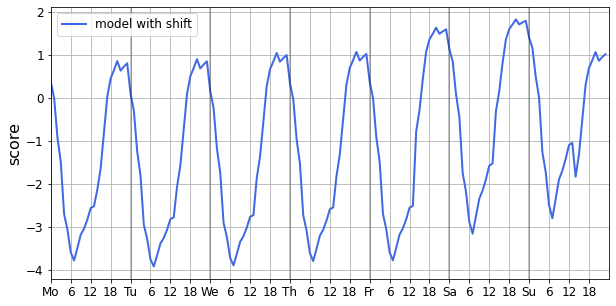

Thai Restaurant 	 item 9074 	 # check-ins: 67


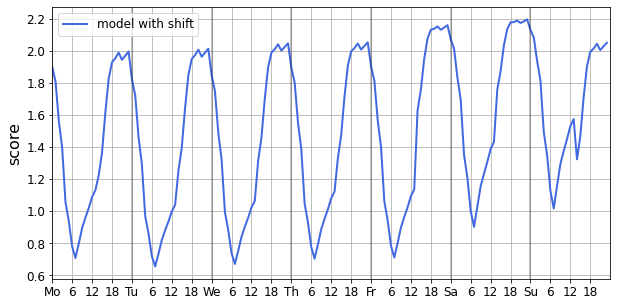

Parking 	 item 14687 	 # check-ins: 66


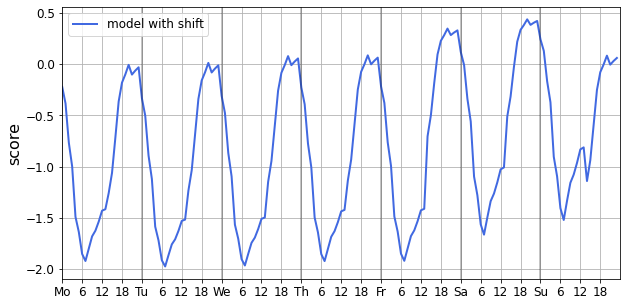

Tattoo Parlor 	 item 18301 	 # check-ins: 66


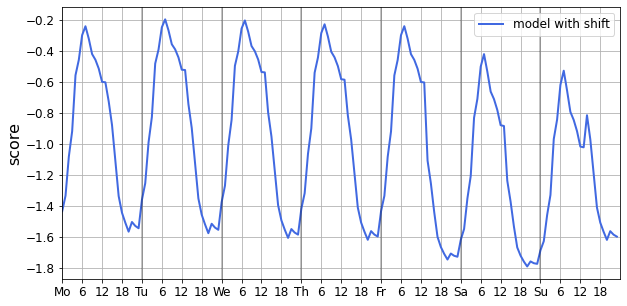

Fast Food Restaurant 	 item 22070 	 # check-ins: 64


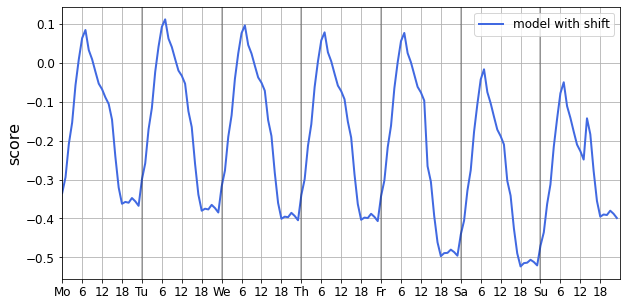

Mexican Restaurant 	 item 35301 	 # check-ins: 63


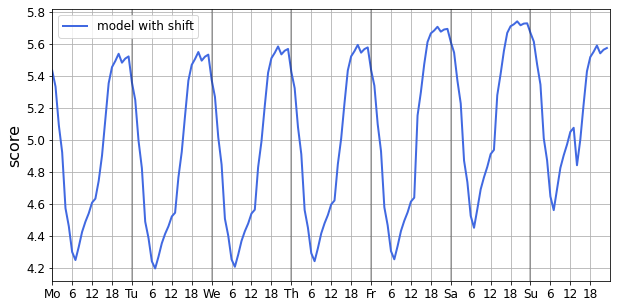

Event Space 	 item 6842 	 # check-ins: 63


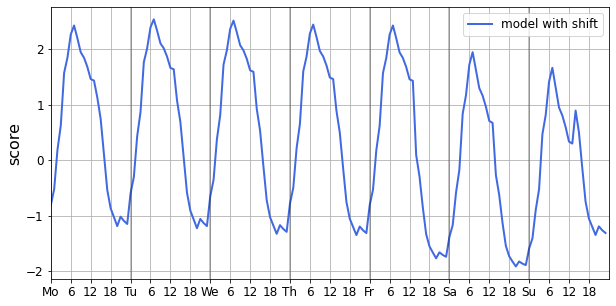

Garden 	 item 29767 	 # check-ins: 61


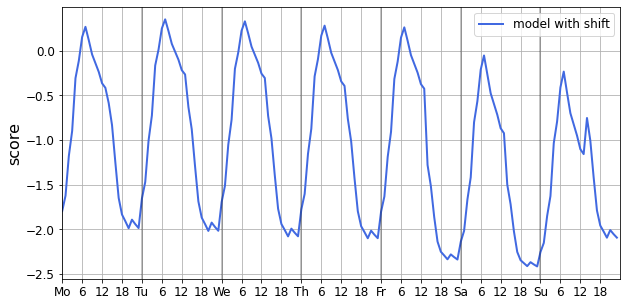

Rest Area 	 item 32033 	 # check-ins: 61


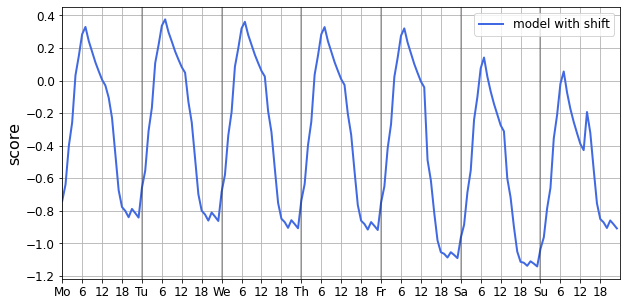

Miscellaneous Shop 	 item 16020 	 # check-ins: 61


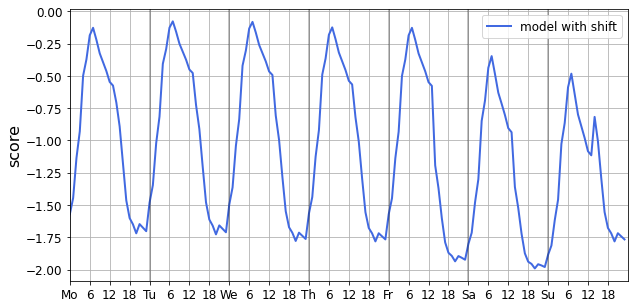

Nursery School 	 item 33985 	 # check-ins: 61


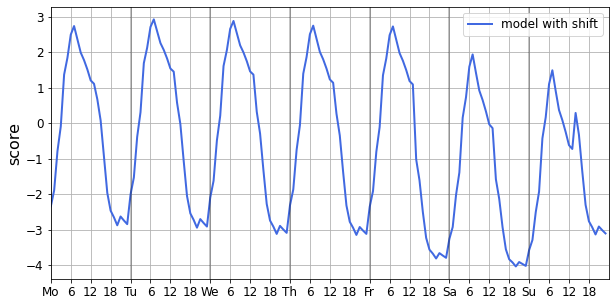

Bakery 	 item 10338 	 # check-ins: 60


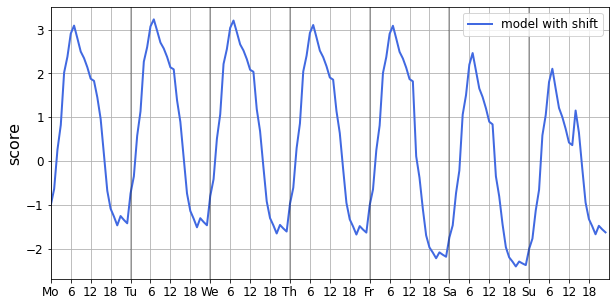

German Restaurant 	 item 24778 	 # check-ins: 59


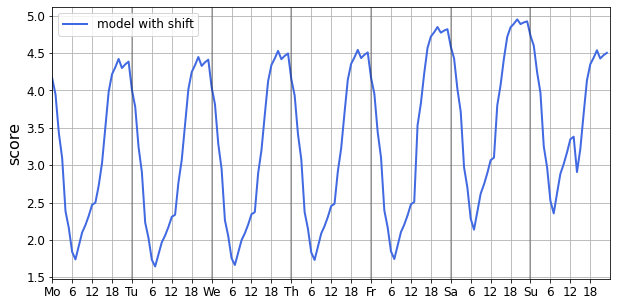

Asian Restaurant 	 item 1912 	 # check-ins: 58


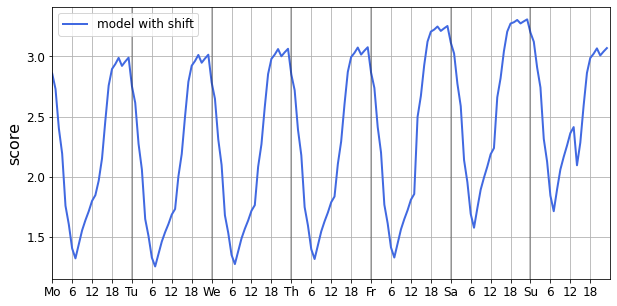

Concert Hall 	 item 2167 	 # check-ins: 58


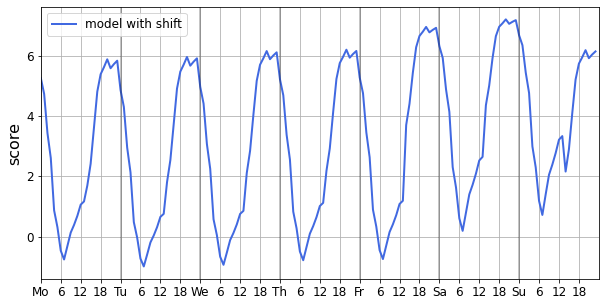

Automotive Shop 	 item 17553 	 # check-ins: 57


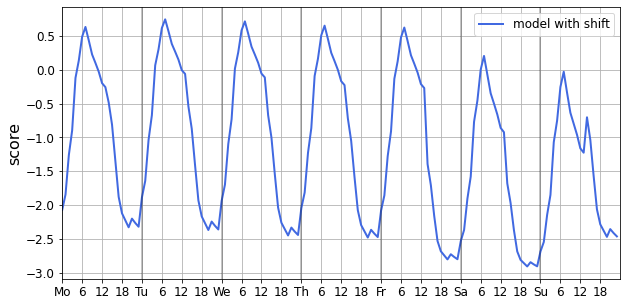

Beer Garden 	 item 5016 	 # check-ins: 57


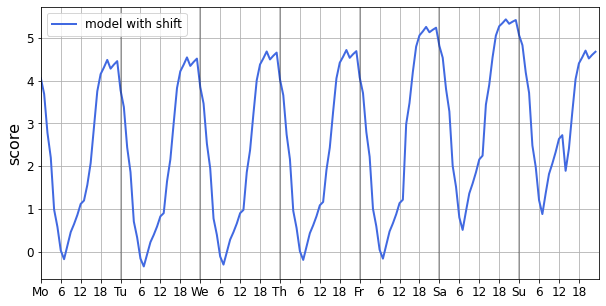

Sporting Goods Shop 	 item 12272 	 # check-ins: 56


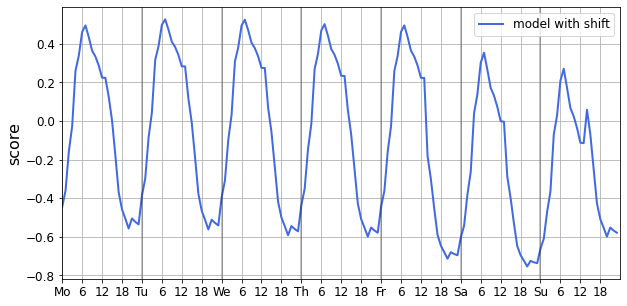

High School 	 item 20555 	 # check-ins: 55


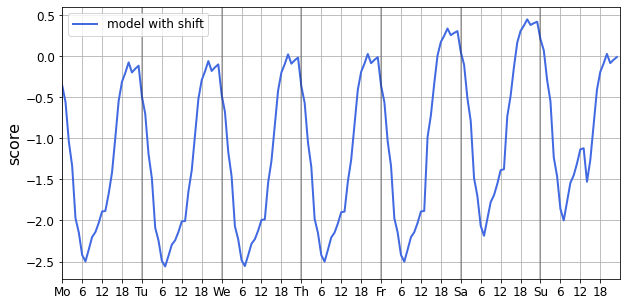

Athletic & Sport 	 item 9290 	 # check-ins: 55


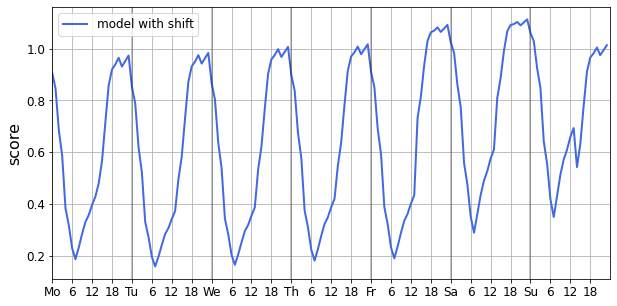

Harbor / Marina 	 item 12567 	 # check-ins: 55


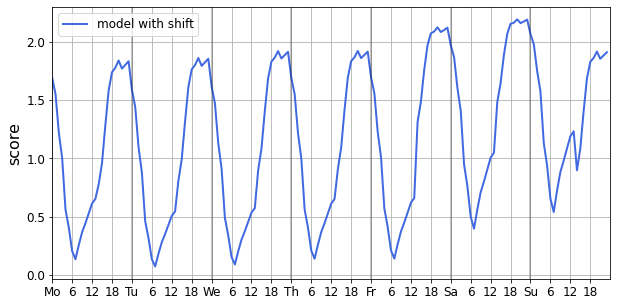

Italian Restaurant 	 item 11467 	 # check-ins: 53


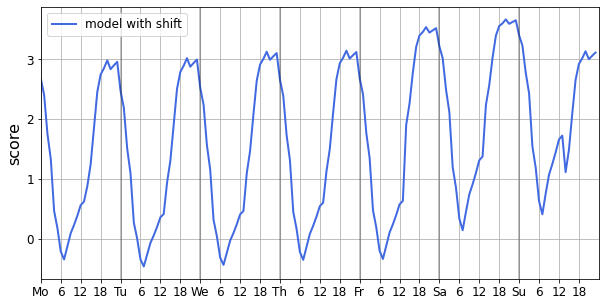

Cafй 	 item 10882 	 # check-ins: 53


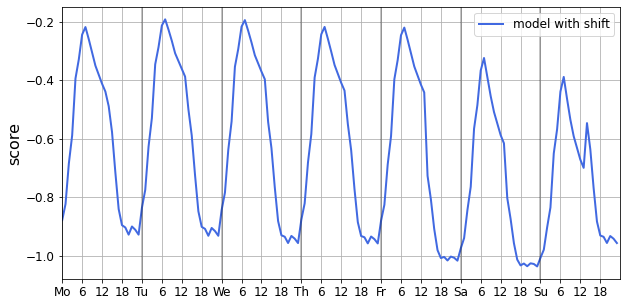

Recycling Facility 	 item 8540 	 # check-ins: 51


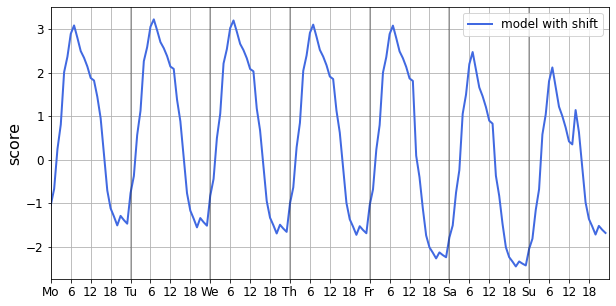

Molecular Gastronomy Restaurant 	 item 30727 	 # check-ins: 50


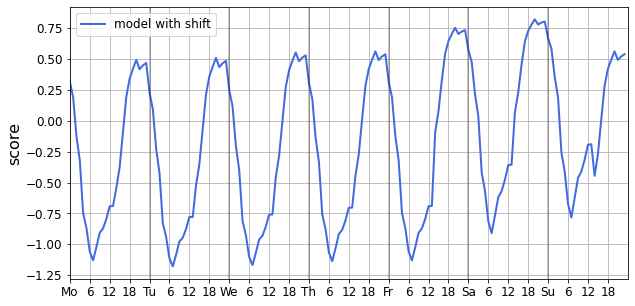

Arts & Entertainment 	 item 26271 	 # check-ins: 50


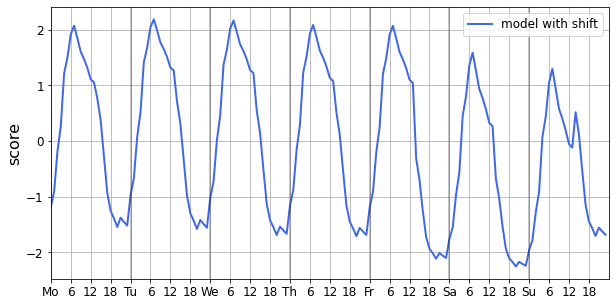

Donut Shop 	 item 15592 	 # check-ins: 50


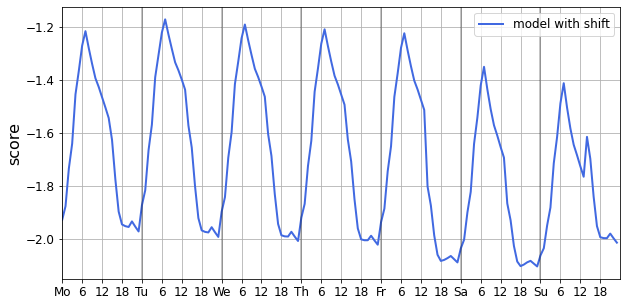

Clothing Store 	 item 22690 	 # check-ins: 50


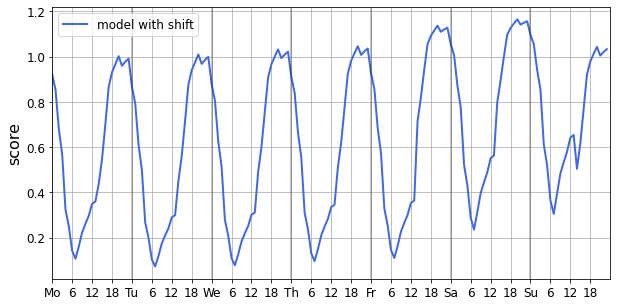

Food Truck 	 item 6807 	 # check-ins: 49


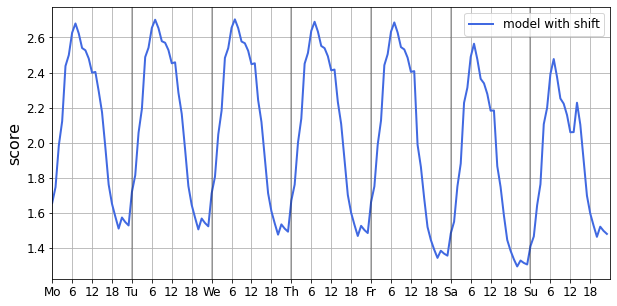

Convenience Store 	 item 37313 	 # check-ins: 49


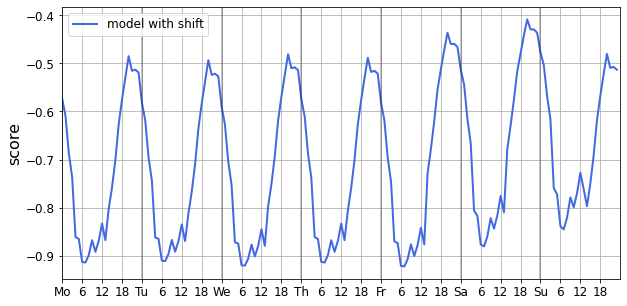

Ramen /  Noodle House 	 item 4130 	 # check-ins: 49


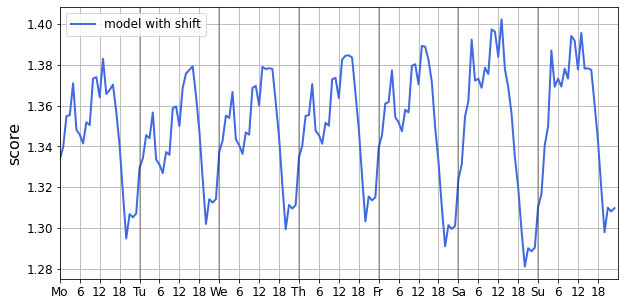

Theater 	 item 7828 	 # check-ins: 48


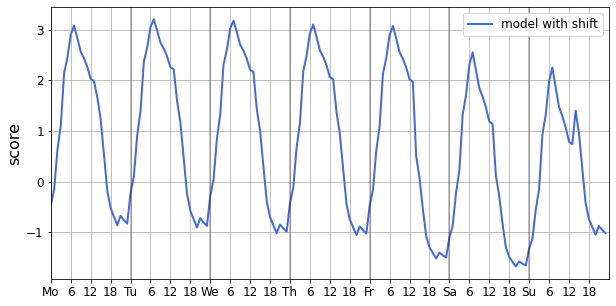

Funeral Home 	 item 34273 	 # check-ins: 47


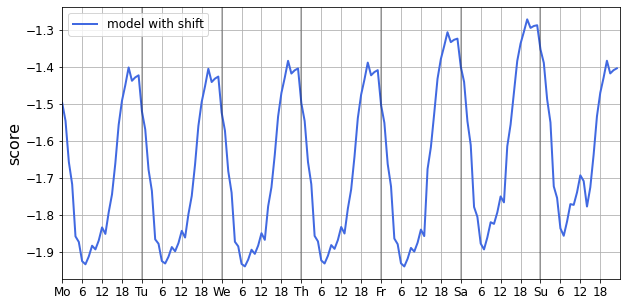

Church 	 item 9323 	 # check-ins: 46


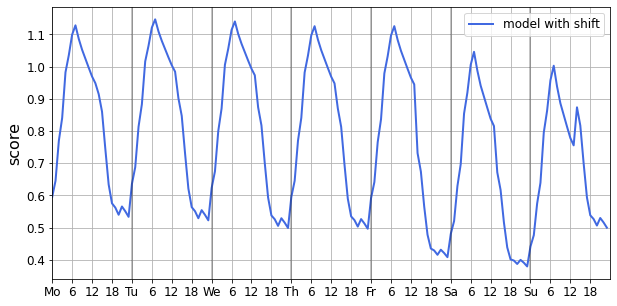

Paper / Office Supplies Store 	 item 10354 	 # check-ins: 46


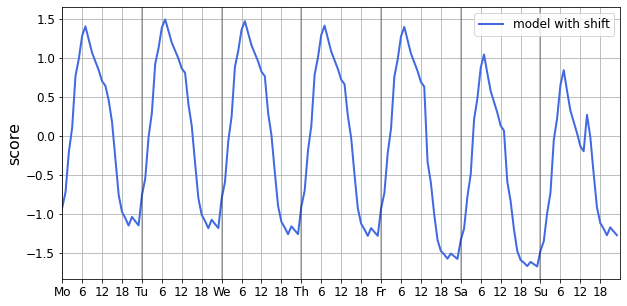

Science Museum 	 item 1316 	 # check-ins: 45


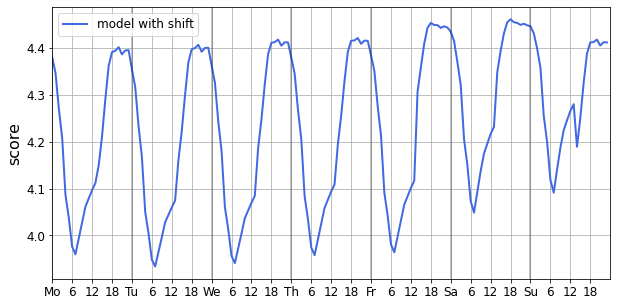

Housing Development 	 item 13302 	 # check-ins: 45


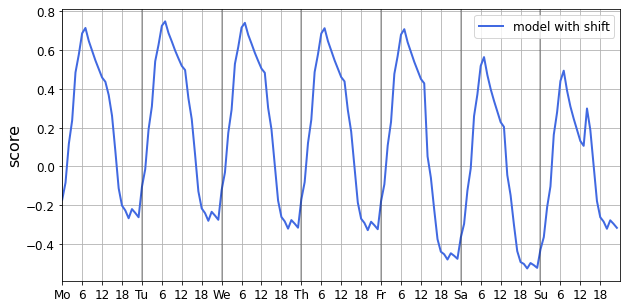

Bagel Shop 	 item 9652 	 # check-ins: 44


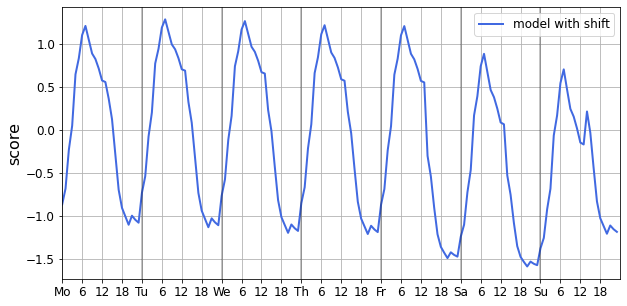

Gastropub 	 item 10143 	 # check-ins: 44


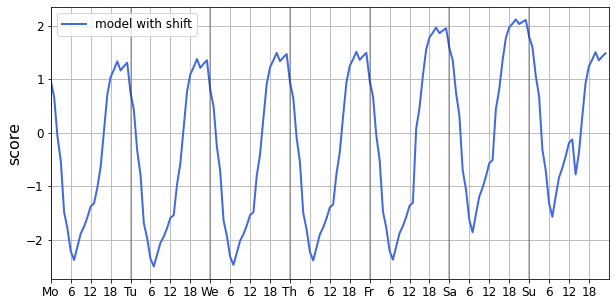

General College & University 	 item 23186 	 # check-ins: 44


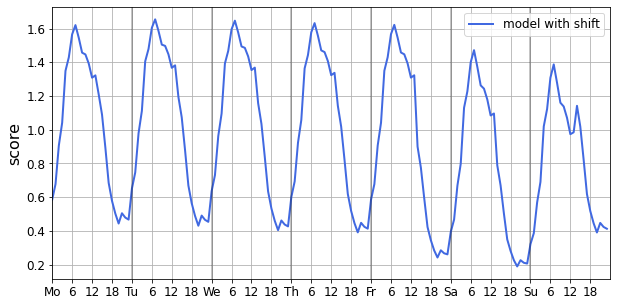

Student Center 	 item 21774 	 # check-ins: 44


KeyboardInterrupt: 

In [89]:
feed_dict = {}
feed_dict['user_id'] = tensor(users_history.index)
feed_dict['history_items'] = tensor(user_history)
feed_dict['lengths'] = tensor(lengths)
feed_dict['batch_size'] = data.user_id.nunique()
feed_dict['phase'] = 'test'

days = np.arange(2,9)
hours = np.arange(24)
grid = np.meshgrid(hours, days)
for k in count_items.keys():
    print(k, '\t item', items[k], '\t # check-ins:', count_items[k])
    feed_dict['item_id'] = tensor([[items[k]] for i in range(data.user_id.nunique())])
    scores = []
    for hour, day in zip(grid[0].flatten(), grid[1].flatten()):
        next_time = (pd.Timestamp("2023-01-{:02d} {:02d}:00:00".format(day, hour)) - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
        real_hour = datetime.fromtimestamp(next_time).hour
        weekday = datetime.fromtimestamp(next_time).weekday()
#         print('hour', hour, '->', real_hour, '\t day', day, '->', weekday)
        user_hourhistory = []
        user_dayhistory = []
        for i, l in users_timehistory.iteritems():
            if len(l) < 19:
                l = l + [next_time] + [0] * (19 - len(l))
            else:
                l = l[-19:] + [next_time]
            user_hourhistory.append([datetime.fromtimestamp(x).hour + 1 for x in l])
            user_dayhistory.append([datetime.fromtimestamp(x).weekday() + 1 for x in l])
        feed_dict['history_hours'] = tensor(user_hourhistory)
        feed_dict['history_hours_shift'] = tensor(user_hourhistory)
        feed_dict['history_days'] = tensor(user_dayhistory)
        feed_dict['history_days_shift'] = tensor(user_dayhistory)
        feed_dict['history_months'] = tensor(user_dayhistory)
        feed_dict['history_months_shift'] = tensor(user_dayhistory)
#             feed_dict['history_times'] = tensor(user_timehistory)
        pred = model(feed_dict)['prediction']
        scores.append(pred.mean().item())
#     orig_pred = orig_model(feed_dict)['prediction']
#     orig_scores = [orig_pred.mean().item()] * len(scores)
    
    fig = plt.figure(figsize=(10,5))
#     plt.title(f'Average score of item of category "{k}" during week')
    plt.plot(np.roll(scores,-7), color='royalblue', linewidth=2, label='model with shift')
#     plt.plot(np.roll(orig_scores,-7), color='k', linestyle='--', label='original model')
    plt.xticks(6*np.arange(4*7), ['Mo', 6, 12, 18, 'Tu', 6, 12, 18, 'We', 6, 12, 18, 'Th', 6, 12, 18, 'Fr', 6, 12, 18, 'Sa', 6, 12, 18, 'Su', 6, 12, 18], fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylabel('score', fontsize=16)
    plt.xlim(0, 24*7)
    plt.grid(True)
    for i in range(1, 7):
        plt.axvline(24*i, color='k', alpha=0.3)
    plt.legend(fontsize=12)
    plt.show()
#     fig.savefig(f'{k}_h,d.svg', format='svg', dpi=1400, bbox_inches='tight')

In [85]:
round(orig_pred[0][0].item(),4)

3.1369

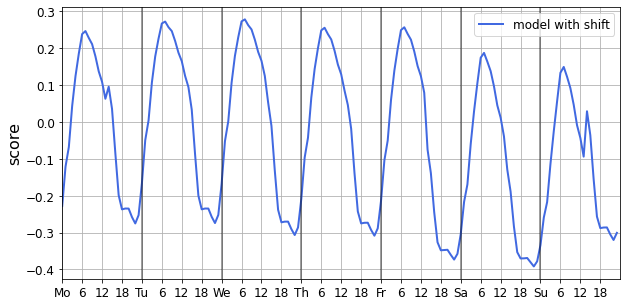

In [108]:
fig = plt.figure(figsize=(10,5))
#     plt.title(f'Average score of item of category "{k}" during week')
plt.plot(np.roll(scores,-7), color='royalblue', linewidth=2, label='model with shift')
# plt.plot(np.roll(orig_scores,-7), color='k', linestyle='--', linewidth=3, label='original model')
plt.xticks(6*np.arange(4*7), ['Mo', 6, 12, 18, 'Tu', 6, 12, 18, 'We', 6, 12, 18, 'Th', 6, 12, 18, 'Fr', 6, 12, 18, 'Sa', 6, 12, 18, 'Su', 6, 12, 18], fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('score', fontsize=16)
plt.xlim(0, 24*7)
plt.grid(True)
for i in range(1, 7):
    plt.axvline(24*i, color='k', alpha=0.5)
plt.legend(fontsize=12)
plt.show()

### hour

In [21]:
args.time_units = 'h'
model = GRU4Rec_shift(args, corpus)

In [22]:
model

GRU4Rec_shift(
  (i_embeddings): Embedding(38335, 64)
  (hour_embeddings): Embedding(25, 64)
  (day_embeddings): Embedding(8, 64)
  (rnn): GRU(128, 128, batch_first=True)
  (out): Linear(in_features=128, out_features=64, bias=True)
)

In [23]:
# h
model.load_state_dict(torch.load('../model/GRU4Rec_shift/GRU4Rec_shift__4Square_NYC__0__lr=0.001__l2=0.0001__emb_size=64__hidden_size=128__time_units=h.pt', map_location=args.device))

<All keys matched successfully>

Coffee Shop 	 item 6366 	 # check-ins: 7510


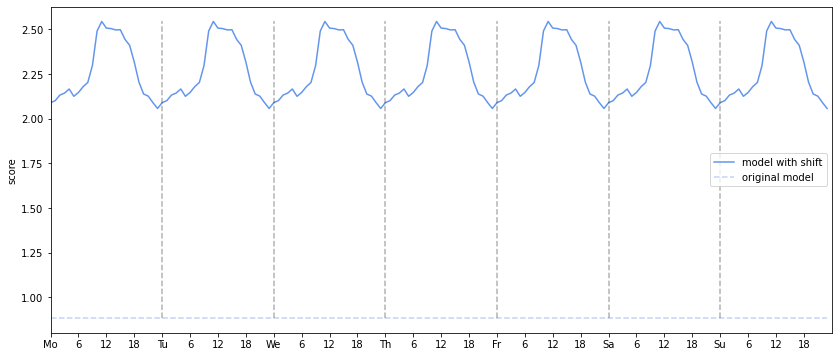

Bar 	 item 33205 	 # check-ins: 15978


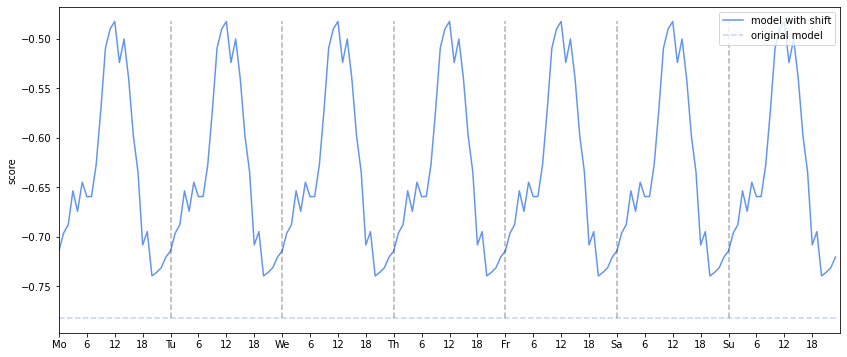

In [24]:
feed_dict = {}
feed_dict['user_id'] = tensor(users_history.index)
feed_dict['history_items'] = tensor(user_history)
feed_dict['lengths'] = tensor(lengths)
feed_dict['batch_size'] = data.user_id.nunique()
feed_dict['phase'] = 'test'

days = np.arange(2,9)
hours = np.arange(24)
grid = np.meshgrid(hours, days)
for k in ['Coffee Shop', 'Bar']:
    print(k, '\t item', items[k], '\t # check-ins:', count_items[k])
    feed_dict['item_id'] = tensor([[items[k]] for i in range(data.user_id.nunique())])
    scores = []
    for hour, day in zip(grid[0].flatten(), grid[1].flatten()):
        next_time = (pd.Timestamp("2023-01-{:02d} {:02d}:00:00".format(day, hour)) - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
        real_hour = datetime.fromtimestamp(next_time).hour
        weekday = datetime.fromtimestamp(next_time).weekday()
#         print('hour', hour, '->', real_hour, '\t day', day, '->', weekday)
        user_timehistory = []
        for i, l in users_timehistory.iteritems():
            if len(l) < 19:
                l = l + [next_time] + [0] * (19 - len(l))
                user_timehistory.append(l)
            else:
                l = l[-19:] + [next_time]
                user_timehistory.append(l)
        feed_dict['history_times'] = tensor(user_timehistory)
        pred = model(feed_dict)['prediction']
        scores.append(pred.mean().item())
    orig_pred = orig_model(feed_dict)['prediction']
    orig_scores = [orig_pred.mean().item()] * len(scores)
    
    fig = plt.figure(figsize=(14,6))
#     plt.title(f'Average score of item of category "{k}" during week')
    plt.plot(np.roll(scores,-7), color='cornflowerblue', label='model with shift')
    plt.plot(np.roll(orig_scores,-7), color='royalblue', linestyle='--', alpha=0.3, label='original model')
    plt.xticks(6*np.arange(4*7), ['Mo', 6, 12, 18, 'Tu', 6, 12, 18, 'We', 6, 12, 18, 'Th', 6, 12, 18, 'Fr', 6, 12, 18, 'Sa', 6, 12, 18, 'Su', 6, 12, 18])
    plt.ylabel('score')
    plt.xlim(0, 24*7)
    for i in range(1, 7):
        plt.vlines(24*i, min(min(scores), orig_scores[0]), max(max(scores), orig_scores[0]), linestyle='--', color='k', alpha=0.3)
        plt.legend()
    plt.show()
    fig.savefig(f'{k}_h.svg', format='svg', dpi=1400)

### day

In [25]:
args.time_units = 'd'
model = GRU4Rec_shift(args, corpus)

In [26]:
model

GRU4Rec_shift(
  (i_embeddings): Embedding(38335, 64)
  (hour_embeddings): Embedding(25, 64)
  (day_embeddings): Embedding(8, 64)
  (rnn): GRU(128, 128, batch_first=True)
  (out): Linear(in_features=128, out_features=64, bias=True)
)

In [27]:
# d
model.load_state_dict(torch.load('../model/GRU4Rec_shift/GRU4Rec_shift__4Square_NYC__0__lr=0.001__l2=0.0001__emb_size=64__hidden_size=128__time_units=d.pt', map_location=args.device))

<All keys matched successfully>

Coffee Shop 	 item 6366 	 # check-ins: 7510


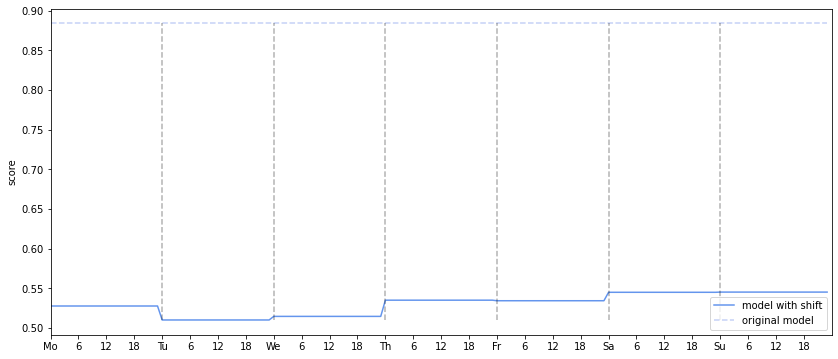

Bar 	 item 33205 	 # check-ins: 15978


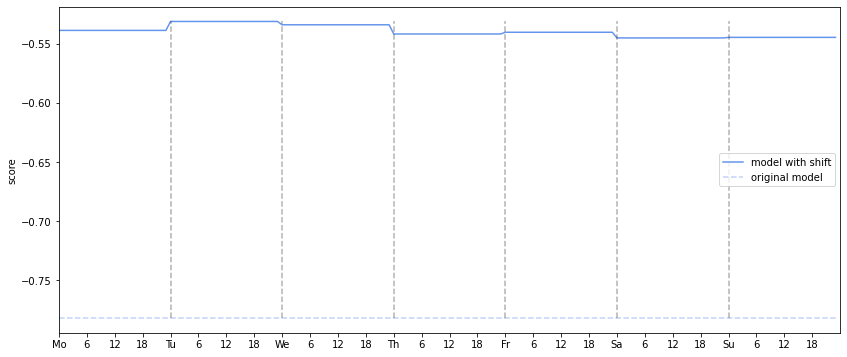

In [32]:
feed_dict = {}
feed_dict['user_id'] = tensor(users_history.index)
feed_dict['history_items'] = tensor(user_history)
feed_dict['lengths'] = tensor(lengths)
feed_dict['batch_size'] = data.user_id.nunique()
feed_dict['phase'] = 'test'

days = np.arange(2,9)
hours = np.arange(24)
grid = np.meshgrid(hours, days)
for k in ['Coffee Shop', 'Bar']:
    print(k, '\t item', items[k], '\t # check-ins:', count_items[k])
    feed_dict['item_id'] = tensor([[items[k]] for i in range(data.user_id.nunique())])
    scores = []
    for hour, day in zip(grid[0].flatten(), grid[1].flatten()):
        next_time = (pd.Timestamp("2023-01-{:02d} {:02d}:00:00".format(day, hour)) - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
        real_hour = datetime.fromtimestamp(next_time).hour
        weekday = datetime.fromtimestamp(next_time).weekday()
#         print('hour', hour, '->', real_hour, '\t day', day, '->', weekday)
        user_timehistory = []
        for i, l in users_timehistory.iteritems():
            if len(l) < 19:
                l = l + [next_time] + [0] * (19 - len(l))
                user_timehistory.append(l)
            else:
                l = l[-19:] + [next_time]
                user_timehistory.append(l)
        feed_dict['history_times'] = tensor(user_timehistory)
        pred = model(feed_dict)['prediction']
        scores.append(pred.mean().item())
    orig_pred = orig_model(feed_dict)['prediction']
    orig_scores = [orig_pred.mean().item()] * len(scores)
    
    fig = plt.figure(figsize=(14,6))
#     plt.title(f'Average score of item of category "{k}" during week')
    plt.plot(np.roll(scores,3), color='cornflowerblue', label='model with shift')
    plt.plot(np.roll(orig_scores,3), color='royalblue', linestyle='--', alpha=0.3, label='original model')
    plt.xticks(6*np.arange(4*7), ['Mo', 6, 12, 18, 'Tu', 6, 12, 18, 'We', 6, 12, 18, 'Th', 6, 12, 18, 'Fr', 6, 12, 18, 'Sa', 6, 12, 18, 'Su', 6, 12, 18])
    plt.ylabel('score')
    plt.xlim(0, 24*7)
    for i in range(1, 7):
        plt.vlines(24*i, min(min(scores), orig_scores[0]), max(max(scores), orig_scores[0]), linestyle='--', color='k', alpha=0.3)
        plt.legend()
    plt.show()
    fig.savefig(f'{k}_d.svg', format='svg', dpi=1400)

## TiSASRec

In [251]:
# parser
parser = argparse.ArgumentParser(description='')
parser.add_argument('--gpu', type=str, default='', help='Set CUDA_VISIBLE_DEVICES, default for CPU only')
parser.add_argument('--random_seed', type=int, default=0, help='Random seed of numpy and pytorch')
parser.add_argument('--history_max', type=int, default=20, help='Maximum length of history.')
parser.add_argument('--dropout', type=float, default=0, help='Dropout probability for each deep layer')
parser.add_argument('--test_all', type=int, default=0, help='Whether testing on all the items.')
parser.add_argument('--emb_size', type=int, default=64, help='Size of embedding vectors.')
parser.add_argument('--hidden_size', type=int, default=128, help='Size of hidden vectors in GRU.')
parser.add_argument('--time_units', type=str, default='h,d', help='Time units for creating time embeddings')
parser.add_argument('--buffer', type=int, default=1, help='Whether to buffer feed dicts for dev/test')
parser.add_argument('--num_neg', type=int, default=1, help='The number of negative items during training.')
parser.add_argument('--num_layers', type=int, default=1, help='The number of negative items during training.')
parser.add_argument('--num_heads', type=int, default=1, help='The number of negative items during training.')
parser.add_argument('--time_max', type=int, default=512, help='The number of negative items during training.')
args, extras = parser.parse_known_args()
args.device = torch.device('cpu')
args.model_path = '/'

In [252]:
orig_model = TiSASRec(args, orig_corpus)

In [253]:
orig_model

TiSASRec(
  (i_embeddings): Embedding(38334, 64)
  (p_k_embeddings): Embedding(21, 64)
  (p_v_embeddings): Embedding(21, 64)
  (t_k_embeddings): Embedding(513, 64)
  (t_v_embeddings): Embedding(513, 64)
  (transformer_block): ModuleList(
    (0): TimeIntervalTransformerLayer(
      (masked_attn_head): TimeIntervalMultiHeadAttention(
        (v_linear): Linear(in_features=64, out_features=64, bias=True)
        (k_linear): Linear(in_features=64, out_features=64, bias=True)
        (q_linear): Linear(in_features=64, out_features=64, bias=True)
      )
      (layer_norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0, inplace=False)
      (linear1): Linear(in_features=64, out_features=64, bias=True)
      (linear2): Linear(in_features=64, out_features=64, bias=True)
      (layer_norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (dropout2): Dropout(p=0, inplace=False)
    )
  )
)

In [254]:
# original
orig_model.load_state_dict(torch.load('../model/TiSASRec_shift/TiSASRec__4Square_NYC__0__lr=0.0001__l2=1e-06__emb_size=64__num_layers=1__num_heads=1__time_max=512.pt', map_location=args.device))

<All keys matched successfully>

### hour, day

In [255]:
args.time_units = 'h,d'
model = TiSASRec_shift(args, orig_corpus)

In [256]:
# h,d
model.load_state_dict(torch.load('../model/TiSASRec_shift/TiSASRec_shift__4Square_NYC__0__lr=0.0001__l2=1e-06__emb_size=64__num_layers=1__num_heads=1__time_max=512__time_units=h,d.pt', map_location=args.device))

<All keys matched successfully>

Coffee Shop 	 item 6366 	 # check-ins: 7510


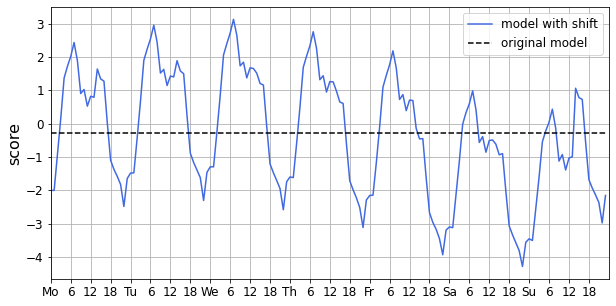

Bar 	 item 33205 	 # check-ins: 15978


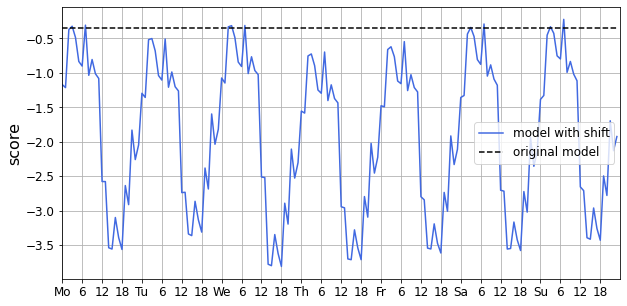

In [257]:
feed_dict = {}
feed_dict['user_id'] = tensor(users_history.index)
min_interval = tensor(list(hd_model.user_min_interval.values()))
feed_dict['user_min_intervals'] = min_interval
feed_dict['history_items'] = tensor(user_history)
feed_dict['lengths'] = tensor(lengths)
feed_dict['batch_size'] = data.user_id.nunique()
feed_dict['phase'] = 'test'

days = np.arange(2,9)
hours = np.arange(24)
grid = np.meshgrid(hours, days)
for k in ['Coffee Shop', 'Bar']:
    print(k, '\t item', items[k], '\t # check-ins:', count_items[k])
    feed_dict['item_id'] = tensor([[items[k]] for i in range(data.user_id.nunique())])
    scores = []
    for hour, day in zip(grid[0].flatten(), grid[1].flatten()):
        next_time = (pd.Timestamp("2023-01-{:02d} {:02d}:00:00".format(day, hour)) - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
        real_hour = datetime.fromtimestamp(next_time).hour
        weekday = datetime.fromtimestamp(next_time).weekday()
#         print('hour', hour, '->', real_hour, '\t day', day, '->', weekday)
        user_timehistory = []
        for i, l in users_timehistory.iteritems():
            if len(l) < 19:
                l = l + [next_time] + [0] * (19 - len(l))
                user_timehistory.append(l)
            else:
                l = l[-19:] + [next_time]
                user_timehistory.append(l)
        feed_dict['history_times'] = tensor(user_timehistory)
        pred = model(feed_dict)['prediction']
        scores.append(pred.mean().item())
    orig_pred = orig_model(feed_dict)['prediction']
    orig_scores = [orig_pred.mean().item()] * len(scores)
    
    fig = plt.figure(figsize=(10,5))
#     plt.title(f'Average score of item of category "{k}" during week')
    plt.plot(np.roll(scores,-7), color='royalblue', label='model with shift')
    plt.plot(np.roll(orig_scores,-7), color='k', linestyle='--', label='original model')
    plt.xticks(6*np.arange(4*7), ['Mo', 6, 12, 18, 'Tu', 6, 12, 18, 'We', 6, 12, 18, 'Th', 6, 12, 18, 'Fr', 6, 12, 18, 'Sa', 6, 12, 18, 'Su', 6, 12, 18], fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylabel('score', fontsize=16)
    plt.xlim(0, 24*7)
    plt.grid(True)
#     for i in range(1, 7):
#         plt.vlines(24*i, min(min(scores), orig_scores[0]), max(max(scores), orig_scores[0]), linestyle='--', color='k', alpha=0.3)
    plt.legend(fontsize=12)
    plt.show()
    fig.savefig(f'tisasrec_{k}_h,d.svg', format='svg', dpi=1400, bbox_inches='tight')